<a href="https://colab.research.google.com/github/puc26/myProject/blob/main/20230811_WATAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

## 1.1 Background

晶圓的製作往往必須經過數百個站點(stage)的加工，製造過程中，晶圓加工的歷史資料(process record)會被自動的記錄與儲存，以作為日後進行分析追 蹤的根據，如圖一所示。而當晶圓加工完畢後，一般會對晶圓進行晶圓允收測試(wafer acceptance test，簡稱 WAT)與探針測試(circuit probe，簡稱CP)以驗證製程的穩定性與晶圓良率(yield)。

## 1.2 Data Description

提供的資料包含兩部分，每片晶圓都有代碼 ID 可以供合併:
1. 晶圓加工的歷史資料(dataX_Tool.csv)
2. 晶圓 WAT 量測結果(dataY_WAT.csv)

## 1.3 Goals and Purpose

請問該如何透過所提供的資料分析影響晶圓 WAT 穩定性的關鍵 站點與機台，並預測尚未進行測試的晶圓可能的 WAT 數值?

請跟 ChatGPT 協作，以下指引步驟逐步進行
1. 請透過探索性資料分析方法客觀的說明資料特性。
2. 依據資料特性，您會做什麼樣的資料預處理? 為什麼?
3. 依據資料特性，您會採用什麼樣的分析方法? 為什麼?
4. 請提供尚未進行測試的晶圓 WAT 預測結果。

請列出關鍵站點與機台，並說明分析流程。若有參考文獻，請一併列出。 請於時限內提供說明簡報與程式碼(附註解)。

# 2. Explorary Data Analysis (EDA)

## 2.1 Aquire Data

In [ ]:
# Data wrangling libraries
import pandas as pd
import numpy as np
import random as rnd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Data Wrangling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Machine Learning Libraries
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

!pip install catboost
from catboost import CatBoostRegressor

# Evaluation Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
import time

# Seed used in this research
seed = 12

In [ ]:
# Download the file from google drive
!gdown --id 1I77h1G73mMMlRiTGCNHM8GIv7QD9Tfjq -O data.xlsx

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1I77h1G73mMMlRiTGCNHM8GIv7QD9Tfjq
To: /content/data.xlsx
100% 917k/917k [00:00<00:00, 45.1MB/s]


In [ ]:
# Read the data
all_sheets = pd.read_excel('data.xlsx', sheet_name=None, engine='openpyxl')

# Peak at the data
for sheet_name, data in all_sheets.items():
    print(f"Sheet name: {sheet_name}")
    print(data.head())

Sheet name: dataX_Tool
     Wafer ID  Stage_A  Stage_B  Stage_C   Stage_D   Stage_E   Stage_F  \
0  Wafer_2367    330.0  Tool_B7  Tool_C5  Tool_D17  Tool_E11   Tool_F6   
1  Wafer_1883    340.0  Tool_B1  Tool_C3   Tool_D9  Tool_E16  Tool_F16   
2  Wafer_2476    340.0  Tool_B8  Tool_C5  Tool_D11  Tool_E10  Tool_F14   
3  Wafer_2303    330.0  Tool_B6  Tool_C3  Tool_D12  Tool_E19   Tool_F1   
4  Wafer_1341    330.0  Tool_B6  Tool_C2   Tool_D9   Tool_E4  Tool_F17   

   Stage_G  Stage_H  Stage_I  ...  Stage_T   Stage_U   Stage_V   Stage_W  \
0  Tool_G2  Tool_H4  Tool_I3  ...  Tool_T2   Tool_U6  Tool_V13   Tool_W4   
1  Tool_G4  Tool_H2  Tool_I2  ...  Tool_T2   Tool_U1   Tool_V6  Tool_W13   
2  Tool_G3  Tool_H2  Tool_I3  ...  Tool_T3   Tool_U1  Tool_V14  Tool_W15   
3  Tool_G4  Tool_H4  Tool_I3  ...  Tool_T5   Tool_U7   Tool_V7  Tool_W15   
4  Tool_G3  Tool_H2  Tool_I3  ...  Tool_T8  Tool_U10  Tool_V29   Tool_W4   

   Stage_X   Stage_Y  Stage_Z   Stage_AA   Stage_AB  Stage_AC  
0  Tool_X3 

## 2.2 Overview

In [ ]:
# Infomation of the data
dataX = all_sheets['dataX_Tool']
dataY = all_sheets['dataY_WAT']

# Combined features and target
all_data = pd.merge(dataX, dataY, on='Wafer ID', how='outer')

print('Shape of dataX: ', dataX.shape[0], 'records and ', dataX.shape[1], 'attributes.')
print('Shape of dataY: ', dataY.shape[0], 'records and ', dataY.shape[1], 'attributes.')
print('Shape of all_data: ', all_data.shape[0], 'records and ', all_data.shape[1], 'attributes.')

Shape of dataX:  5442 records and  30 attributes.
Shape of dataY:  4358 records and  2 attributes.
Shape of all_data:  5442 records and  31 attributes.


The discrepancies in the record count between dataX_Tool and dataY_WAT arise from certain target values that haven't been tested yet. These untested values are reserved for subsequent forecasting.

In [ ]:
# Check the first few rows of whole data
all_data.head()

,Wafer ID,Stage_A,Stage_B,Stage_C,Stage_D,Stage_E,Stage_F,Stage_G,Stage_H,Stage_I,...,Stage_U,Stage_V,Stage_W,Stage_X,Stage_Y,Stage_Z,Stage_AA,Stage_AB,Stage_AC,Mean
0,Wafer_2367,330.0,Tool_B7,Tool_C5,Tool_D17,Tool_E11,Tool_F6,Tool_G2,Tool_H4,Tool_I3,...,Tool_U6,Tool_V13,Tool_W4,Tool_X3,Tool_Y11,Tool_Z5,Tool_AA1,Tool_AB14,Tool_AC6,0.481437
1,Wafer_1883,340.0,Tool_B1,Tool_C3,Tool_D9,Tool_E16,Tool_F16,Tool_G4,Tool_H2,Tool_I2,...,Tool_U1,Tool_V6,Tool_W13,Tool_X3,Tool_Y7,Tool_Z9,Tool_AA6,Tool_AB4,Tool_AC5,0.524745
2,Wafer_2476,340.0,Tool_B8,Tool_C5,Tool_D11,Tool_E10,Tool_F14,Tool_G3,Tool_H2,Tool_I3,...,Tool_U1,Tool_V14,Tool_W15,Tool_X4,Tool_Y7,Tool_Z4,NaN,Tool_AB14,Tool_AC6,0.554639
3,Wafer_2303,330.0,Tool_B6,Tool_C3,Tool_D12,Tool_E19,Tool_F1,Tool_G4,Tool_H4,Tool_I3,...,Tool_U7,Tool_V7,Tool_W15,Tool_X5,Tool_Y6,Tool_Z7,Tool_AA14,Tool_AB17,Tool_AC5,0.546427
4,Wafer_1341,330.0,Tool_B6,Tool_C2,Tool_D9,Tool_E4,Tool_F17,Tool_G3,Tool_H2,Tool_I3,...,Tool_U10,Tool_V29,Tool_W4,Tool_X1,Tool_Y4,Tool_Z6,Tool_AA7,Tool_AB6,Tool_AC1,0.526412


In [ ]:
# Check data types
all_data.dtypes

Wafer ID     object
Stage_A     float64
Stage_B      object
Stage_C      object
Stage_D      object
Stage_E      object
Stage_F      object
Stage_G      object
Stage_H      object
Stage_I      object
Stage_J      object
Stage_K      object
Stage_L      object
Stage_M      object
Stage_N      object
Stage_O      object
Stage_P      object
Stage_Q      object
Stage_R      object
Stage_S      object
Stage_T      object
Stage_U      object
Stage_V      object
Stage_W      object
Stage_X      object
Stage_Y      object
Stage_Z      object
Stage_AA     object
Stage_AB     object
Stage_AC     object
Mean        float64
dtype: object

* Two features are of float type, with one serving as the target feature.
* Out of 29 object-type features, 28 will be utilized in the test dataset, excluding the "Wafer ID" column.

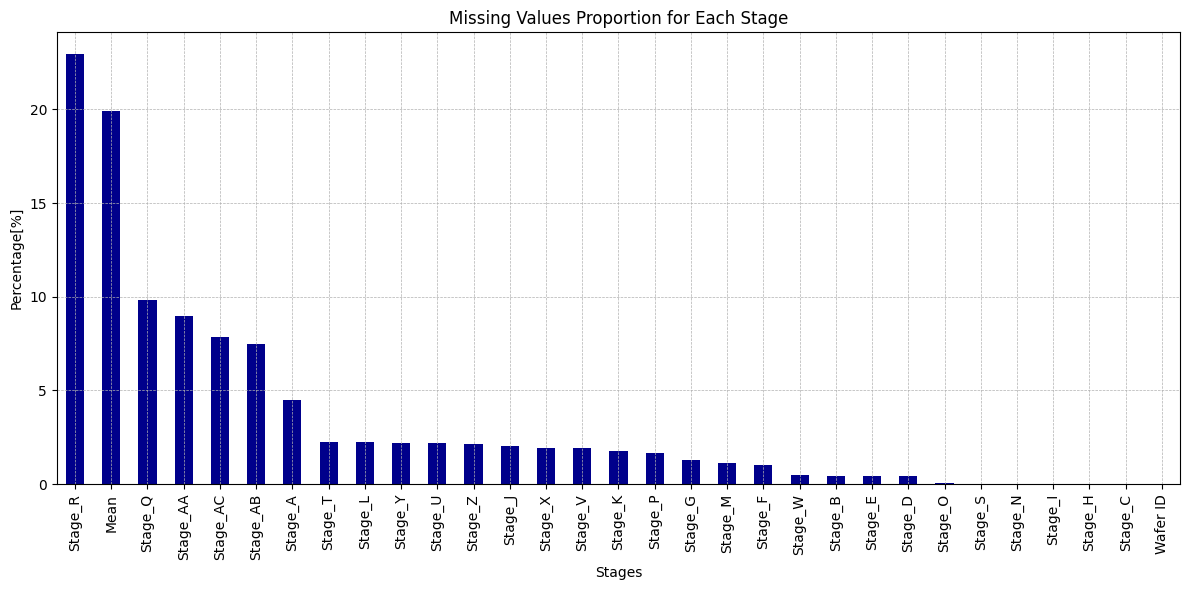

In [ ]:
# Calcualte the number of missing values
missing = all_data.isnull().sum()
missing_percent = (all_data.isnull().sum() / len(all_data)) * 100

# Plot the result
plt.figure(figsize=(12, 6))
missing_percent.sort_values(ascending=False).plot(kind='bar', color='darkblue')
plt.title('Missing Values Proportion for Each Stage')
plt.ylabel('Percentage[%]')
plt.xlabel('Stages')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

* Several features exhibit missing values.
* "Stage_R" has the most significant proportion of missing values, approximately 23%, while the rest are below 10%.
* The target column, "Mean", has about 20% missing values, representing the ratio of untested chips set aside for subsequent predictions.

## 2.3 Numerical Features

In [ ]:
# Distribution of numerical columns
all_data.describe()

,Stage_A,Mean
count,5197.000000,4358.000000
mean,329.069656,0.536163
std,6.131212,0.024337
min,320.000000,0.426343
25%,330.000000,0.519746
50%,330.000000,0.534756
75%,330.000000,0.551817
max,355.000000,0.630071


From the descriptive statistics, we can draw several key points:

* The standard deviation for Stage_A stands at 6.13, while for Mean, it's 0.024. This suggests that the data for Mean is more tightly clustered around its average, whereas the values for Stage_A exhibit a broader spread.
* The 25th, 50th (median), and 75th percentiles for Stage_A are all at or below 330, highlighting that a significant portion of the Stage_A data is centered around this value. On the other hand, the values for Mean appear to be more uniformly distributed throughout its range.

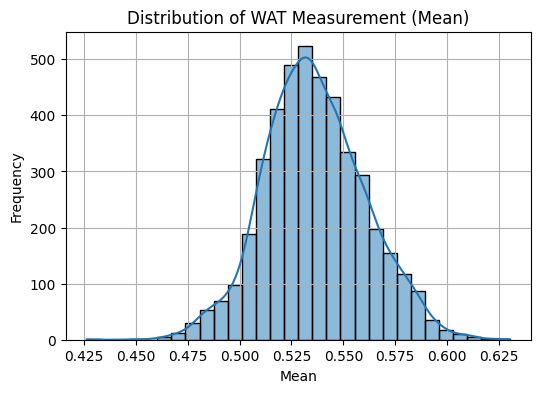

In [ ]:
# Plot distribution of Mean
plt.figure(figsize=(6, 4))
sns.histplot(all_data['Mean'], kde=True, bins=30)
plt.title('Distribution of WAT Measurement (Mean)')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

From the histogram of the Mean, the distribution of the Mean data appears uniform and most of the measured values are concentrated in the range of 0.5 to 0.6, closely resembling a normal distribution.

In [ ]:
# Calculate correlation between Stage_A and Mean
correlation = all_data[['Stage_A', 'Mean']].corr()
correlation

,Stage_A,Mean
Stage_A,1.000000,-0.120344
Mean,-0.120344,1.000000


The correlation coefficient is about -0.12, indicating a slight negative correlation between of two.

In [ ]:
# Count the unique values for Stage_A
all_data['Stage_A'].value_counts()

330.0    3375
320.0    1157
340.0     564
355.0      42
335.0      34
325.0      25
Name: Stage_A, dtype: int64

From our analysis, it's evident that the Stage_A values are limited in variety, and the distribution of those values ​​is not continuous.

Notably, the most frequent category is centered around 330. This distribution suggests that Stage_A behaves more like a categorical variable rather than a continuous numerical one.

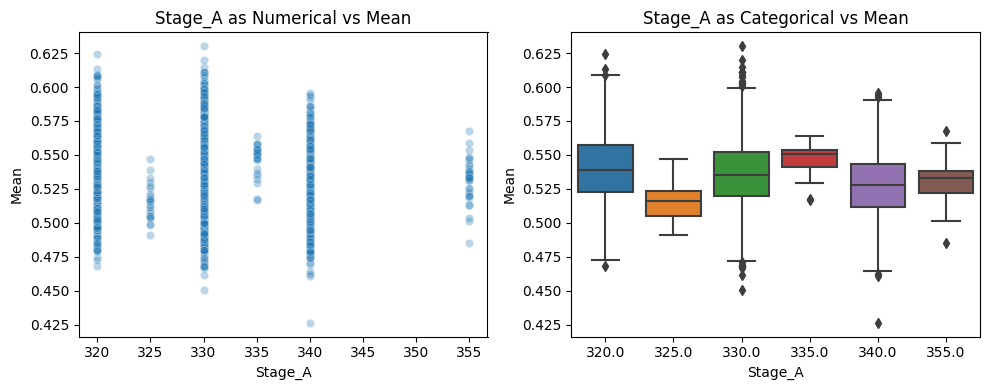

In [ ]:
# Extracting non-missing Stage_A values
non_missing_stage_a = all_data[~all_data['Stage_A'].isnull()]

# Setting up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the correlation for Stage_A as numerical
sns.scatterplot(x='Stage_A', y='Mean', data=non_missing_stage_a, ax=ax[0], alpha=0.3)
ax[0].set_title('Stage_A as Numerical vs Mean')
ax[0].set_xlabel('Stage_A')
ax[0].set_ylabel('Mean')

# Plotting the distribution for Stage_A as categorical
sns.boxplot(x='Stage_A', y='Mean', data=non_missing_stage_a, ax=ax[1])
ax[1].set_title('Stage_A as Categorical vs Mean')
ax[1].set_xlabel('Stage_A')
ax[1].set_ylabel('Mean')

plt.tight_layout()
plt.show()

**As a Numerical Variable:**  
The scatter plot indicates that there isn't a distinct linear correlation between Stage_A and Mean.

**As a Categorical Variable:**  
The box plot illustrates variations in the Mean across different Stage_A values, suggesting that distinct Stage_A values do correspond to different Mean values.

In conclusion, considering Stage_A as a categorical variable might provide a clearer insight into its relationship with Mean, we will treat it as a categorical feature afterward.

In [ ]:
# Change datatype of Stage_A
all_data["Stage_A"] = all_data["Stage_A"].astype(str)
all_data.dtypes

Wafer ID     object
Stage_A      object
Stage_B      object
Stage_C      object
Stage_D      object
Stage_E      object
Stage_F      object
Stage_G      object
Stage_H      object
Stage_I      object
Stage_J      object
Stage_K      object
Stage_L      object
Stage_M      object
Stage_N      object
Stage_O      object
Stage_P      object
Stage_Q      object
Stage_R      object
Stage_S      object
Stage_T      object
Stage_U      object
Stage_V      object
Stage_W      object
Stage_X      object
Stage_Y      object
Stage_Z      object
Stage_AA     object
Stage_AB     object
Stage_AC     object
Mean        float64
dtype: object

## 2.4 Categorical Features

In [ ]:
categorical_cols = all_data.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop('Wafer ID')

In [ ]:
all_data.describe(include=['O'])

,Wafer ID,Stage_A,Stage_B,Stage_C,Stage_D,Stage_E,Stage_F,Stage_G,Stage_H,Stage_I,...,Stage_T,Stage_U,Stage_V,Stage_W,Stage_X,Stage_Y,Stage_Z,Stage_AA,Stage_AB,Stage_AC
count,5442,5442,5418,5442,5419,5419,5386,5373,5442,5442,...,5319,5323,5338,5417,5336,5323,5326,4954,5035,5015
unique,5442,7,8,5,20,27,19,4,4,15,...,9,11,30,15,5,11,11,14,19,8
top,Wafer_2367,330.0,Tool_B2,Tool_C2,Tool_D9,Tool_E21,Tool_F7,Tool_G2,Tool_H3,Tool_I14,...,Tool_T5,Tool_U1,Tool_V7,Tool_W12,Tool_X5,Tool_Y7,Tool_Z11,Tool_AA13,Tool_AB14,Tool_AC7
freq,1,3375,1161,1403,546,634,553,1824,2474,1192,...,1109,1012,624,1055,1635,879,770,678,399,916


In [ ]:
# Descriptive statistics to each feature
categorical_statistic = all_data[categorical_cols].nunique().reset_index()
categorical_statistic.columns = ['Feature', 'No. of Uniques']
categorical_statistic = categorical_statistic.sort_values(by='No. of Uniques', ascending=False)
categorical_statistic.head(10)

,Feature,No. of Uniques
12,Stage_M,55
21,Stage_V,30
4,Stage_E,27
3,Stage_D,20
14,Stage_O,19
27,Stage_AB,19
5,Stage_F,19
18,Stage_S,17
15,Stage_P,17
8,Stage_I,15


In [ ]:
categorical_statistic.tail(10)

,Feature,No. of Uniques
10,Stage_K,10
19,Stage_T,9
28,Stage_AC,8
1,Stage_B,8
0,Stage_A,7
13,Stage_N,6
23,Stage_X,5
2,Stage_C,5
7,Stage_H,4
6,Stage_G,4


The number of unique values ​​for a feature ranges from 4 to 55. Stage_M has the most unique values ​​at 55, while Stage_G and Stage_H have the fewest unique values at 4.

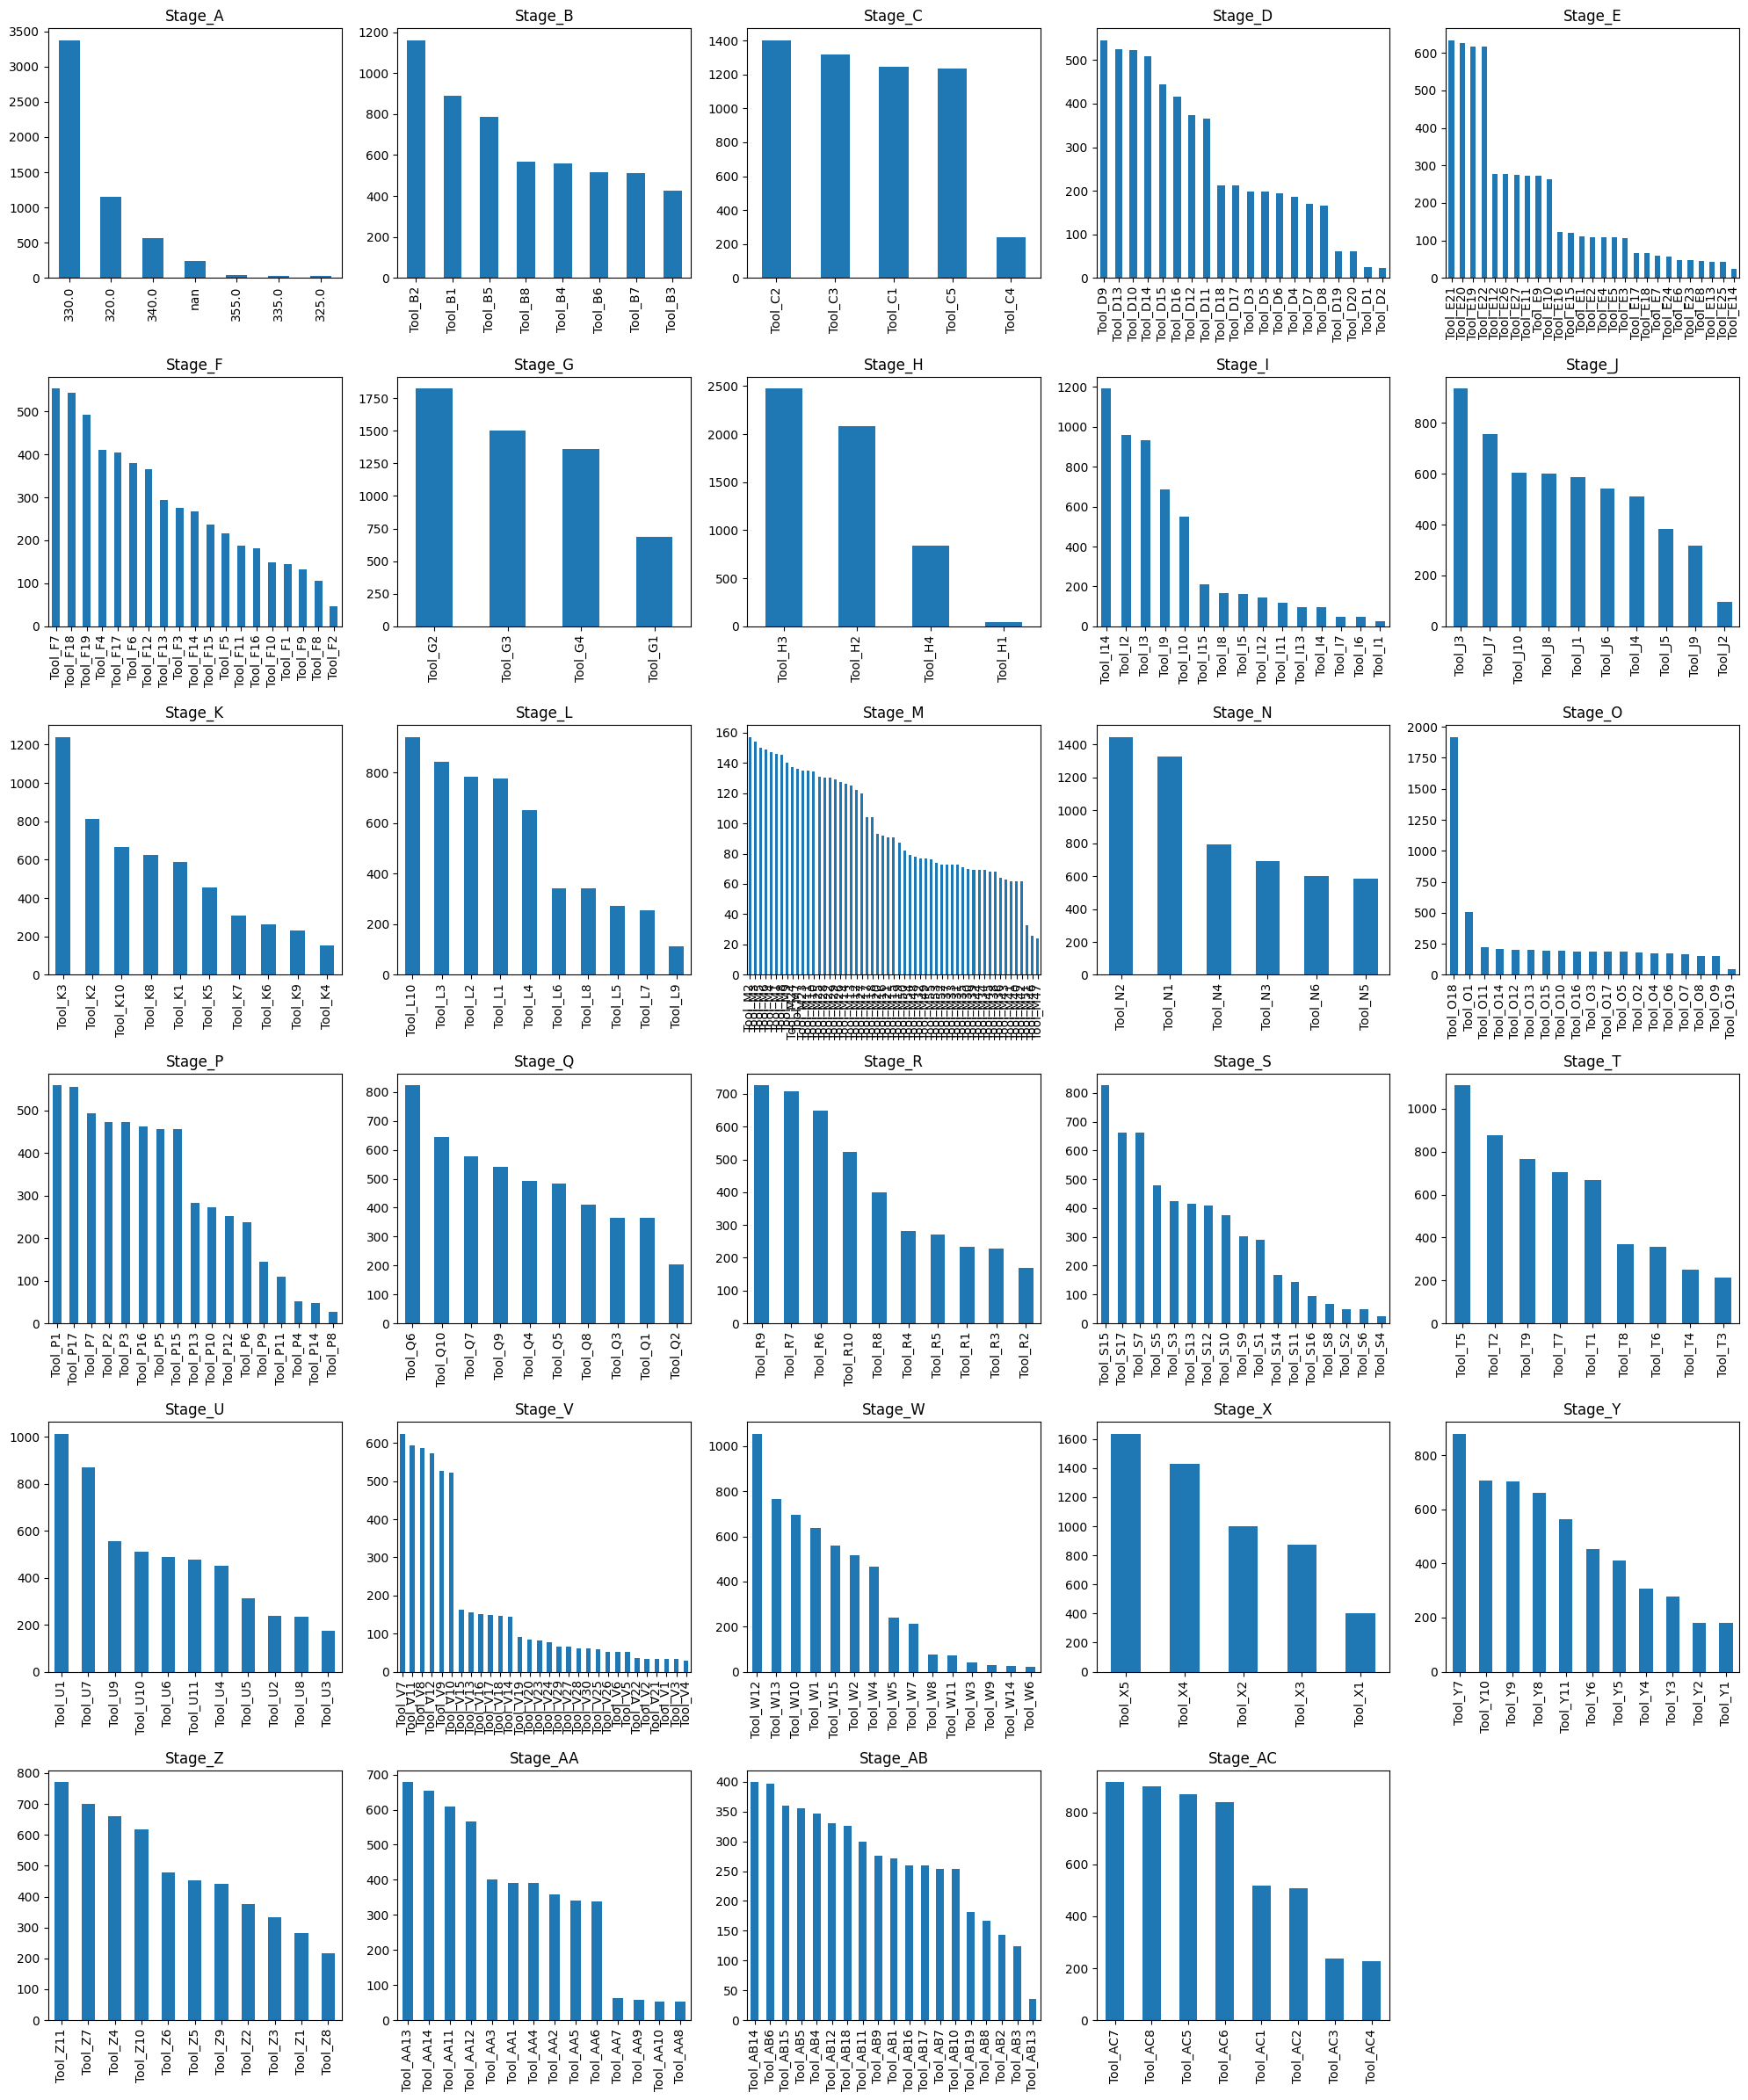

In [ ]:
# Plotting the bar plots for each categorical column
num_categorical = len(categorical_cols)
rows = (num_categorical // 5) + (1 if num_categorical % 5 else 0)
plt.figure(figsize=(20, rows * 4))

for index, column in enumerate(categorical_cols, 1):
    plt.subplot(rows, 5, index)
    all_data[column].value_counts().plot(kind='bar')
    plt.title(column)
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()

* Categories of each feature are correctly marked.
* Each feature has multiple possible categories, and there are several main categories.
* There are several low-count categories in some features, which may be caused some noise to the model.


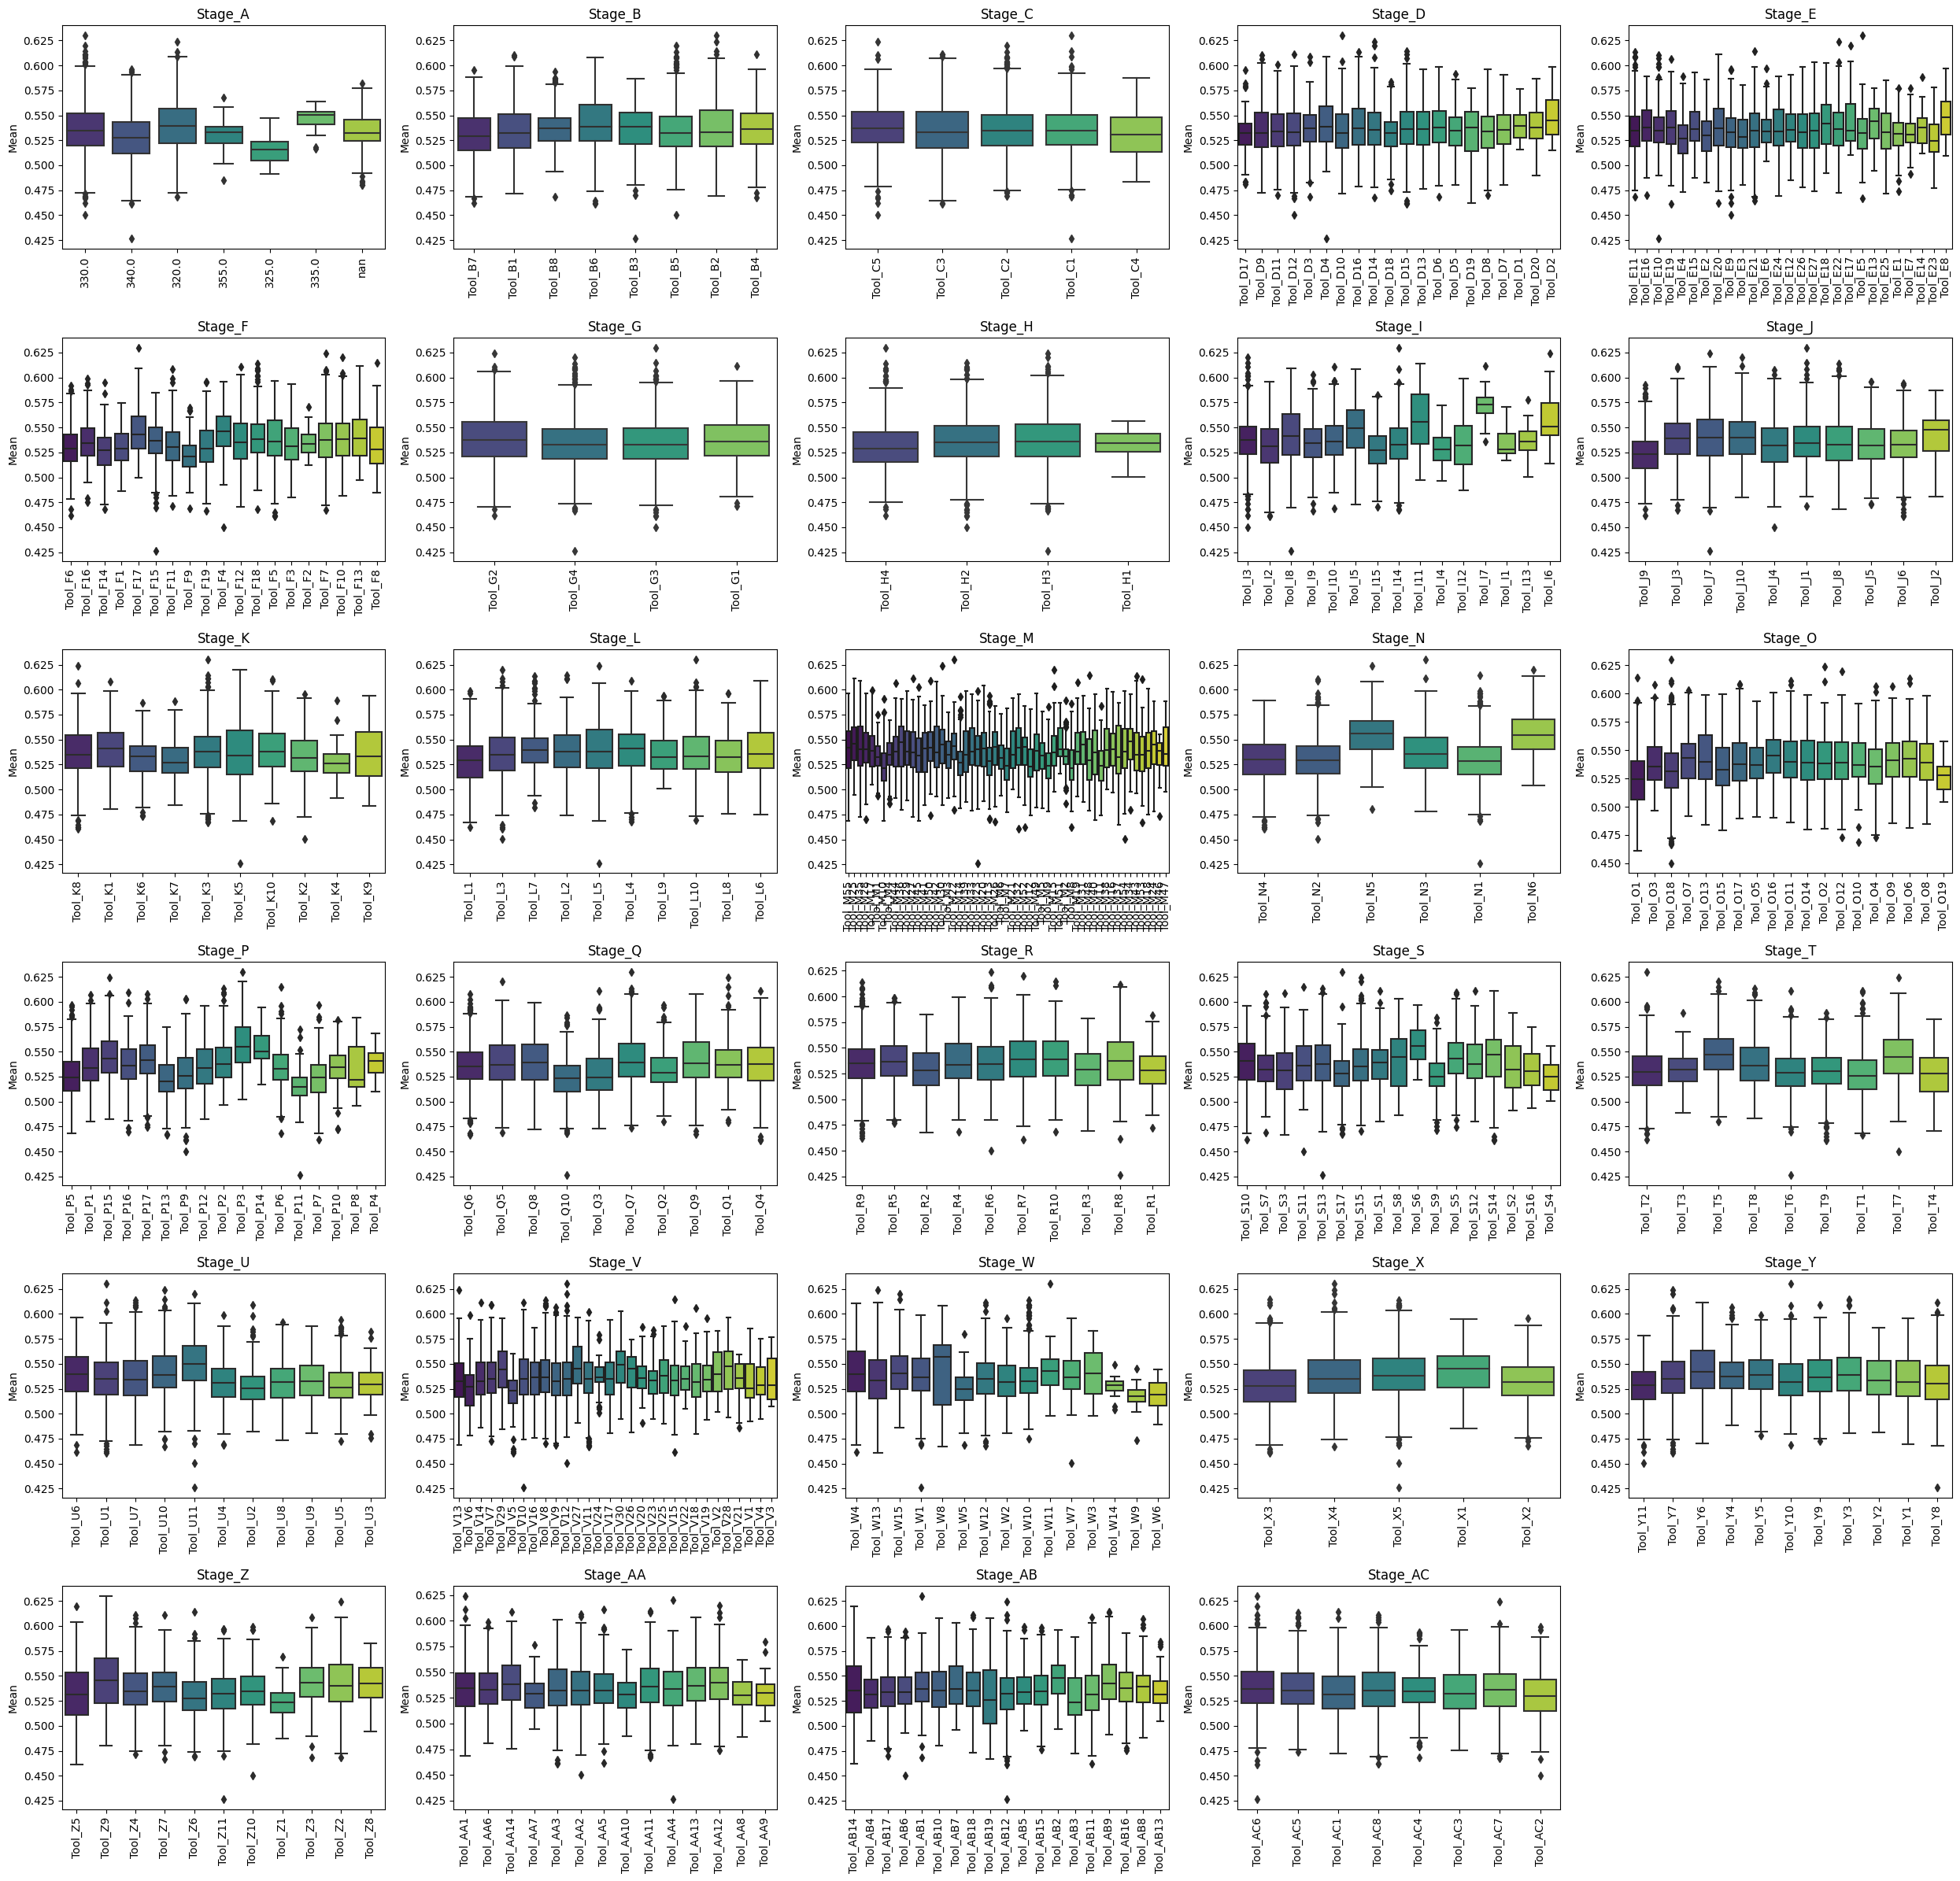

In [ ]:
# Adjusting the layout for plotting
num_categorical = len(categorical_cols)
rows = (num_categorical // 5) + (1 if num_categorical % 5 else 0)

# Plotting the bar plots for each categorical column
plt.figure(figsize=(25, rows * 4))

for index, column in enumerate(categorical_cols, 1):
    plt.subplot(rows, 5, index)
    sns.boxplot(data=all_data, x=column, y='Mean', palette='viridis')
    plt.title(column)
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()

For all the features analyzed, we observe that the average of Mean for most categories doesn't show significant deviation from the overall average of Mean. This suggests that the categories within these features exert a comparable influence on the target variable, Mean. It also implies that no specific category predominantly affects Mean. The impact of these features on the target might be accumulative or interactive in nature.

#### Summary of Features Analysis
* The dataset comprises categorical features with multiple categories.
* Some categories within these features are dominant, while others are less frequent.
The less frequent categories might introduce noise to the model.
* No single category appears to notably influence the target variable, Mean.
* The influence on Mean seems to stem from the collective impact of these categories, either accumulatively or interactively.
* Considering the categories with low frequency potentially produce noise to the model, it will merge into one category named 'others' for each feature.

## 2.5 Missing Values

Given the nature of the dataset, where features are represented by ambiguous codenames, it's challenging to discern the precise implications of each "Stage." With respect to missing values, we can hypothesize two scenarios:  

**Missing Values Indicate Irrelevance or Data Collection Issues:**  
* The missing values might not hold any substantial meaning.
* Despite undergoing data processing, there might have been issues in the collection or storage of data for certain stages.

**Missing Values are Informative:**  
* Certain wafers might not have passed through specific processing stages, indicating the station's role was either skipped or optional.

From the result, we noticed that the missing values of Stage_R is exceed 20%, but it still has a certain correlation. Although not very high, it also shows that the target value tends to be higher when there are missing values, indicating some kind of hidden information.

Method: Fill 'unknown' and create a new binary feature.

In [ ]:
# Create a binary column for missing data for each categorical columns
missing_indicators = all_data[categorical_cols].isnull().astype(int)
missing_indicators.columns = [col for col in missing_indicators.columns]

# Merge the missing indicators with the target
missing_indicators = pd.concat([missing_indicators, all_data['Mean']], axis=1)

# Calculate correlation of missing values with the target
missing_correlations = missing_indicators.corr()['Mean'].drop('Mean')

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage (%)': missing_percent,
    'Correlation': missing_correlations}).drop(['Wafer ID', 'Mean'], axis=0).sort_values(by='Correlation', ascending=False)
missing_df

,Missing Count,Percentage (%),Correlation
Stage_Q,534,9.812569,0.054657
Stage_B,24,0.441014,0.043518
Stage_R,1250,22.969497,0.015684
Stage_T,123,2.260198,0.008998
Stage_G,69,1.267916,-0.002728
Stage_Y,119,2.186696,-0.009211
Stage_X,106,1.947813,-0.014166
Stage_M,60,1.102536,-0.022423
Stage_AC,427,7.846380,-0.023627
Stage_Z,116,2.131569,-0.024545


* The correlations between missing values ​​for all Stages and Mean are between -0.1 and 0.1, indicating that missing values ​​for these features are less significantly related to Mean.  

* Missing values ​​for Stage_Q, Stage_B, and Stage_R are positively correlated with Mean, but relatively weakly, but Stage_Q have the highest correlation with target values.

* Of all stages, Stage_E and Stage_D display the most pronounced negative correlation with Mean.  

* Several Stages, such as Stage_C and Stage_H, yield a correlation value of NaN. This arises because these Stages lack any missing values throughout the dataset.  



#### Summary of Missing Values Analysis
The data reveals that the missing values in various Stages are only faintly correlated with Mean. While some stages like Stage_Q, Stage_B, and Stage_R have a mild positive relationship, others like Stage_E and Stage_D lean more negatively.

This analysis underscores the importance of careful handling and imputation of missing data, as it might still have nuanced implications on the target variable, Mean.

# 3. Data Preprocessing

## 3.1 Missing Values

Based on the insights derived from the analysis of missing values and the exploratory data analysis, we can hypothesize two potential reasons for the missingness: they could either be random (meaningless) or systematic (meaningful).

**For the random or meaningless missing values:**  
  Imputing with the mode (most frequent value) appears suitable, especially for features that display a dominant category distribution.

**For systematic or meaningful missing values:**  
  Binarization might offer enhanced clarity. By transforming these into binary meta-features, we could more effectively capture underlying patterns, potentially enhancing the model's robustness. However, it's crucial to strike a balance. Binarizing every feature would double the number of columns, given that all existing features are categorical. This not only increases the model's complexity and computational requirements but also makes the results more challenging to interpret.

### Influential Missing Values Feature


For the highest missing values feature, a straightforward approach here is to fill missing values with 'unknown' for the largest missing values stages (Stage_R), and the highest correlation with target of feature (Stage_Q) for both situations. The goal of this strategy is to retain pivotal information about the missing values while minimizing the feature set's complexity.

In [ ]:
# Fill missing values with 'unknown' to Stage_R
all_data['Stage_R'].fillna('unknown', inplace=True)
all_data['Stage_R'].value_counts()

unknown     1250
Tool_R9      726
Tool_R7      709
Tool_R6      649
Tool_R10     524
Tool_R8      399
Tool_R4      282
Tool_R5      272
Tool_R1      234
Tool_R3      229
Tool_R2      168
Name: Stage_R, dtype: int64

In [ ]:
# Fill missing values with 'unknown' to Stage_Q
all_data['Stage_Q'].fillna('unknown', inplace=True)
all_data['Stage_Q'].value_counts()

Tool_Q6     823
Tool_Q10    646
Tool_Q7     578
Tool_Q9     540
unknown     534
Tool_Q4     492
Tool_Q5     484
Tool_Q8     411
Tool_Q3     365
Tool_Q1     365
Tool_Q2     204
Name: Stage_Q, dtype: int64

In [ ]:
# Check the missing values again, notice that Stage_R already filled
all_data[categorical_cols].isnull().sum()

Stage_A       0
Stage_B      24
Stage_C       0
Stage_D      23
Stage_E      23
Stage_F      56
Stage_G      69
Stage_H       0
Stage_I       0
Stage_J     110
Stage_K      97
Stage_L     121
Stage_M      60
Stage_N       0
Stage_O       2
Stage_P      89
Stage_Q       0
Stage_R       0
Stage_S       0
Stage_T     123
Stage_U     119
Stage_V     104
Stage_W      25
Stage_X     106
Stage_Y     119
Stage_Z     116
Stage_AA    488
Stage_AB    407
Stage_AC    427
dtype: int64

### Two Strategies


Building on our earlier discussion, we will address the two distinct scenarios of missing values – those that are random (or meaningless) and those that are systematic (or meaningful).

For clarity in our subsequent steps, we'll label the random missing values as 'A' and the systematic ones as 'B'.

In [ ]:
# Random missing values (Method A)
# Fill missing values in all categorical columns with the mode
all_data_A = all_data.copy()
for col in categorical_cols:
    mode_val = all_data[col].mode()[0]
    all_data_A[col].fillna(mode_val, inplace=True)

# Check the filled result
missing_values_A = all_data_A[categorical_cols].isnull().sum()
if len(missing_values_A[missing_values_A > 0]) == 0:
  print('No missing values in all_data_A.')

No missing values in all_data_A.


In [ ]:
# Meaningful missing values (Method B)
# Fill missing values in all categorical columns with 'unknown'
all_data_B = all_data.copy()
for col in categorical_cols:
    all_data_B[col].fillna('unknown', inplace=True)

# Check the filled result
missing_values_B = all_data_A[categorical_cols].isnull().sum()
if len(missing_values_B[missing_values_B > 0]) == 0:
  print('No missing values in all_data_B.')

No missing values in all_data_B.


## 3.2 Outliers

For categorical features, outliers typically manifest as categories with notably low occurrences. From our prior analysis, it's clear that these infrequent categories result from the use of varied tools. To minimize the noise these sparse categories might introduce and to enhance the generalization (prevent over-fitting) of the model, we will consolidate them into a collective category labeled 'others'.

In [ ]:
# Define a function to calculate the categories below the threshold and assigned them to label 'others'
def category_proportions(data, threshold):
    low_freq_categories = []

    for col in categorical_cols:
        proportions = data[col].value_counts(normalize=True)
        low_freq = proportions[proportions < threshold]
        for index, value in low_freq.items():
            low_freq_categories.append({'Feature': col, 'Category': index, 'Proportion': value})

    return pd.DataFrame(low_freq_categories).sort_values(by=['Feature', 'Proportion'])

# Applying the function
threshold = 0.01
low_freq_A = category_proportions(all_data_A, threshold)
low_freq_B = category_proportions(all_data_B, threshold)

low_freq_A, low_freq_B

(     Feature   Category  Proportion
 2    Stage_A      325.0    0.004594
 1    Stage_A      335.0    0.006248
 0    Stage_A      355.0    0.007718
 39  Stage_AA  Tool_AA10    0.009923
 40  Stage_AA   Tool_AA8    0.009923
 41  Stage_AB  Tool_AB13    0.006431
 4    Stage_D    Tool_D2    0.004226
 3    Stage_D    Tool_D1    0.004594
 10   Stage_E   Tool_E14    0.004410
 8    Stage_E   Tool_E13    0.007902
 9    Stage_E   Tool_E25    0.007902
 7    Stage_E    Tool_E8    0.008269
 6    Stage_E   Tool_E23    0.008637
 5    Stage_E    Tool_E6    0.008820
 11   Stage_F    Tool_F2    0.008637
 12   Stage_H    Tool_H1    0.008820
 15   Stage_I    Tool_I1    0.004594
 13   Stage_I    Tool_I7    0.009188
 14   Stage_I    Tool_I6    0.009188
 18   Stage_M   Tool_M47    0.004410
 17   Stage_M   Tool_M46    0.004778
 16   Stage_M   Tool_M51    0.006064
 19   Stage_O   Tool_O19    0.008637
 22   Stage_P    Tool_P8    0.004778
 21   Stage_P   Tool_P14    0.008820
 20   Stage_P    Tool_P4    0.009555
 

It can be observed that discrepancies in the results between A and B are due to different missing value imputation strategies. And we can notice that many features have multiple categories smaller than the threshold (1% used in this research).

When consolidating rare categories into "others", we intentionally excluded "unknown". Merging "unknown" with categories under "others" could blur the interpretation of this category. Notably, in certain contexts, "unknown" might have a specific correlation with the target variable. Combining it might prevent the model from capturing this relationship accurately. Hence, to retain this crucial information we will keep "unknown" as an independent category.

In [ ]:
# Function to combine low frequency categories into 'others'
def combine_low_freq_categories(dataset, threshold):
    for col in categorical_cols:
        mask = (dataset[col].value_counts(normalize=True) < threshold) & (dataset[col].value_counts(normalize=True).index != 'unknown')
        low_freq_cats = mask[mask].index

        dataset[col] = dataset[col].apply(lambda x: 'others' if x in low_freq_cats else x)
    return dataset

# Applying on both datasets
all_data_A = combine_low_freq_categories(all_data_A, threshold)
all_data_B = combine_low_freq_categories(all_data_B, threshold)

In [ ]:
# Check the result (Stage_B for example)
stage_d_df = pd.DataFrame({
    'Original': all_data['Stage_D'].value_counts(),
    'Method A': all_data_A['Stage_D'].value_counts(),
    'Method B': all_data_B['Stage_D'].value_counts()})

stage_d_df

,Original,Method A,Method B
Tool_D1,25.0,NaN,NaN
Tool_D10,524.0,524.0,524.0
Tool_D11,365.0,365.0,365.0
Tool_D12,374.0,374.0,374.0
Tool_D13,526.0,526.0,526.0
Tool_D14,509.0,509.0,509.0
Tool_D15,445.0,445.0,445.0
Tool_D16,417.0,417.0,417.0
Tool_D17,213.0,213.0,213.0
Tool_D18,213.0,213.0,213.0


The NaN in Method A and Method B indicating the low frequency categories, and were merged into 'others'.

## 3.3 Split the Data

In [ ]:
# Splitting the datasets into train and predict datasets based on the presence of 'Mean'
train_A = all_data_A[all_data_A['Mean'].notna()].drop('Wafer ID', axis=1)
predict_A = all_data_A[all_data_A['Mean'].isna()]

train_B = all_data_B[all_data_B['Mean'].notna()].drop('Wafer ID', axis=1)
predict_B = all_data_B[all_data_B['Mean'].isna()]

train_A.shape, predict_A.shape, train_B.shape, predict_B.shape

((4358, 30), (1084, 31), (4358, 30), (1084, 31))

In [ ]:
X_A = train_A.copy()
Y_A = X_A.pop('Mean')

X_B = train_B.copy()
Y_B = X_B.pop('Mean')

In [ ]:
# Train-Test split
X_train_A, X_test_A, Y_train_A, Y_test_A = train_test_split(X_A, Y_A, test_size=0.2, shuffle=True, random_state=seed)
X_train_B, X_test_B, Y_train_B, Y_test_B = train_test_split(X_B, Y_B, test_size=0.2, shuffle=True, random_state=seed)

## 3.4 ANOVA

In [ ]:
# Compute ANOVA
def anova_analysis(X_train, Y_train):
  anova_results = pd.DataFrame(columns=['Feature', 'F_value', 'p_value'])
  for col in categorical_cols:
      cat_groups = [Y_train[X_train[col] == cat] for cat in X_train[col].unique()]
      f_val, p_val = f_oneway(*cat_groups)
      temp_df = pd.DataFrame({'Feature': [col], 'F_value': [f_val], 'p_value': [p_val]})
      anova_results = pd.concat([anova_results, temp_df], axis=0, ignore_index=True)

  anova_results = anova_results.sort_values(by='p_value')

  return anova_results

In [ ]:
anova_analysis(X_train_A, Y_train_A)

,Feature,F_value,p_value
13,Stage_N,159.685213,3.625610e-153
15,Stage_P,43.684806,2.121450e-111
19,Stage_T,48.550015,1.008419e-74
16,Stage_Q,21.987042,2.520816e-40
8,Stage_I,17.634403,2.157161e-37
25,Stage_Z,19.582707,1.380359e-35
12,Stage_M,5.495128,2.387422e-32
5,Stage_F,11.274743,2.913759e-32
20,Stage_U,17.645885,9.166081e-32
14,Stage_O,11.067216,1.481877e-31


In [ ]:
anova_analysis(X_train_B, Y_train_B)

,Feature,F_value,p_value
13,Stage_N,159.685213,3.625610e-153
15,Stage_P,40.945690,4.509396e-111
19,Stage_T,45.275642,1.539363e-77
16,Stage_Q,21.987042,2.520816e-40
8,Stage_I,17.634403,2.157161e-37
25,Stage_Z,17.797389,6.294832e-35
14,Stage_O,11.354511,3.794389e-34
5,Stage_F,10.965095,9.398641e-33
12,Stage_M,5.405187,4.149243e-32
20,Stage_U,16.170458,2.046693e-31


From the ANOVA analysis of two strategies:
* Stage_N is consistently the most significant feature across both sets, indicating a robust association with the target variable.
* Stage_P and Stage_T also demonstrate strong correlations in both analyses.
* Most features exhibit statistically significant relevance (p-value < 0.05) with the target variable in both sets.  

The rankings of features remain relatively consistent between the two result sets, suggesting stable ANOVA outcomes. In general, Stage_N, Stage_P, and Stage_T are pivotal features based on their strong correlation with the target.

## 3.5 Cramér's V

In [ ]:
# Function to compute Cramér's V value
def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return (phi2corr / min(kcorr-1, rcorr-1))**0.5

# Analyzing pairwise relationships between the first 5 features
features_subset = all_data.columns[1:29]  # Excluding "Wafer ID"
cramers_v_values = []

# Compute Cramér's V values for pairwise relationships
for i in range(len(features_subset)):
    for j in range(i+1, len(features_subset)):
        feature1 = features_subset[i]
        feature2 = features_subset[j]

        contingency = pd.crosstab(all_data[feature1], all_data[feature2])
        cramers_v_val = cramers_v(contingency)

        cramers_v_values.append((feature1, feature2, cramers_v_val))

# Convert results into DataFrame
cramers_v_df = pd.DataFrame(cramers_v_values, columns=["Feature 1", "Feature 2", "Cramér's V"])
cramers_v_df.sort_values(by="Cramér's V", ascending=False).head(15)

,Feature 1,Feature 2,Cramér's V
168,Stage_H,Stage_I,0.469149
178,Stage_H,Stage_S,0.441495
127,Stage_F,Stage_I,0.321230
207,Stage_J,Stage_K,0.317160
278,Stage_N,Stage_T,0.312410
13,Stage_A,Stage_O,0.305844
339,Stage_S,Stage_Z,0.295286
128,Stage_F,Stage_J,0.294460
139,Stage_F,Stage_U,0.293288
208,Stage_J,Stage_L,0.288998


The value of Cramér's V spans between 0 and 1, with 0 signifying no association and 1 denoting a perfect association. Based on Cramér's V analysis results, several features exhibit low to moderate correlations. Given these correlations, it would be prudent to opt for models that are less sensitive to feature interdependence, such as tree-based models.

## 3.6 Categorical Encoding

In our dataset, the features are all categorical, and each feature has multiple unique values, using encoding techniques like One Hot Encoding  (OHE) would significantly increase the dimensionality of the data. Given the multitude of unique categories across the features, this would result in a proliferation of columns with a majority of them being sparse (having a large number of zeros). Such an increase in sparsity not only burdens computational performance but might also introduce unnecessary noise into the model.  

To circumvent these challenges and maintain a manageable data dimension, methods used here are **Label encoding**, **Frequency encoding**, and **Target encoding**. These methods effectively capture the essence of the categorical data without causing a dramatic rise in dimensionality, making them particularly suited for our dataset's characteristics.

### 3.5.1 Label Encoding

Label encoding is a simple and computationally lean method. While it preserves the data's dimensionality, the assignment of integers to each category can potentially lead some models to misconstrue the ordinal relationships between categories. Hence, it's not always ideal for models sensitive to numerical magnitude, like linear regression.

In [ ]:
# Label encoding
def label_encode_data(train_data, test_data):
  train_copy = train_data.copy()
  test_copy = test_data.copy()

  le_dict = {}
  for col in categorical_cols:
    le = LabelEncoder()
    train_copy[col] = le.fit_transform(train_copy[col])
    test_copy[col] = le.transform(test_copy[col])
    le_dict[col] = le

  return train_copy, test_copy, le_dict

X_train_A_le, X_test_A_le, le_dict_A = label_encode_data(X_train_A, X_test_A)
X_train_B_le, X_test_B_le, le_dict_B = label_encode_data(X_train_B, X_test_B)

### 3.5.2 Frequency Encoding

Frequency encoding is a common method when navigating extensive datasets or when the categorical features contain a broad of unique entries. One of its advantages is that it operates independently from the target value, effectively eliminating the possibility of data leakage. This approach inherently reduces the risk of overfitting. However, the frequency encoding might lead to a potential loss of information that's directly tied to the target value.

In [ ]:
# Build the frequency dict
def frequency_maps(data):
  freq_maps = {}
  for col in categorical_cols:
      freq_maps[col] = data[col].value_counts(normalize=True).to_dict()
  return freq_maps

freq_map_A = frequency_maps(X_train_A)
freq_map_B = frequency_maps(X_train_B)

In [ ]:
# Frequency encoding
def frequency_encode(data, frequency_maps):
  encoded_data = data.copy()
  for col in categorical_cols:
    if col in frequency_maps:
      encoded_data[col] = encoded_data[col].map(frequency_maps[col])

  return encoded_data

X_train_A_freq = frequency_encode(X_train_A, freq_map_A)
X_test_A_freq = frequency_encode(X_test_A, freq_map_A)
X_train_B_freq = frequency_encode(X_train_B, freq_map_B)
X_test_B_freq = frequency_encode(X_test_B, freq_map_B)

In [ ]:
# Check if contain NaNs
print('No. of missing values:')
print('X_train_A_freq: ', X_train_A_freq.isnull().sum().sum(),\
      '\nX_test_A_freq: ', X_test_A_freq.isnull().sum().sum(),\
      '\nX_train_B_freq: ', X_train_B_freq.isnull().sum().sum(),\
      '\nX_test_B_freq: ', X_test_B_freq.isnull().sum().sum())

No. of missing values:
X_train_A_freq:  0 
X_test_A_freq:  0 
X_train_B_freq:  0 
X_test_B_freq:  0


### 3.5.3 Target Encoding

Target encoding emerges as an efficient method, especially useful when dealing with categorical features boasting numerous unique values. A main advantage is its ability to integrate the relationship between category and target directly into the feature, often enhancing model performance. Furthermore, it adeptly handles high-cardinality categories without significantly increasing data dimensions.

In [ ]:
# Target encoding
def target_maps(data, target_col):
  target_maps = {}
  for col in categorical_cols:
    target_maps[col] = data.groupby(col)[target_col].mean().to_dict()
  return target_maps

# Combine train test data
train_data_A = pd.concat([X_train_A, Y_train_A], axis=1)
train_data_B = pd.concat([X_train_B, Y_train_B], axis=1)

target_map_A = target_maps(train_data_A, 'Mean')
target_map_B = target_maps(train_data_B, 'Mean')

In [ ]:
# Target encoding
def target_encode(data, target_map):
  encoded_data = data.copy()
  for col in categorical_cols:
    if col in target_map:
      encoded_data[col] = encoded_data[col].map(target_map[col])

  return encoded_data

X_train_A_target = target_encode(X_train_A, target_map_A)
X_test_A_target = target_encode(X_test_A, target_map_A)
X_train_B_target = target_encode(X_train_B, target_map_B)
X_test_B_target = target_encode(X_test_B, target_map_B)

In [ ]:
# Check if contain NaNs
print('No. of missing values:')
print('X_train_A_target: ', X_train_A_target.isnull().sum().sum(),\
      '\nX_test_A_target: ', X_test_A_target.isnull().sum().sum(),\
      '\nX_train_B_target: ', X_train_B_target.isnull().sum().sum(),\
      '\nX_test_B_target: ', X_test_B_target.isnull().sum().sum())

No. of missing values:
X_train_A_target:  0 
X_test_A_target:  0 
X_train_B_target:  0 
X_test_B_target:  0


For the above encoding methods, it's imperative to employ a strategy that prevents data leakage. We first determine the relevant frequencies or target averages exclusively using the training data. Once these values are computed, they are then mapped onto the test data. This ensures that the test set remains independent and unbiased, further promoting a more realistic evaluation of the model's performance.

# 4. Build the models

Since the target value is continuous, we are dealing with a regression problem. In addition, considering that the features are all categorical data and the applicability of coding, the following models can be used:

1. **Tree-Based Regression** (e.g., Decision Tree, Random Forest):
* Non-linear models like these can capture non-linear relationships between features and the target, which can handle the nuances of the encoded features.
* Decision trees can split the data based on frequency values, which can help in identifying patterns related to the target value based on frequencies.
* Random forests combine multiple decision trees, enhancing the robustness and accuracy of the model, and capturing patterns that might be overlooked by a single decision tree.

2. **Gradient Boosting Machines** (e.g., XGBoost, LightGBM, or CatBoost):
* Gradient boosting machines build decision trees iteratively, adjusting based on the errors of previous trees.
* GBMs can automatically capture non-linear relationships in features, making them highly suitable for frequency-encoded data.

## 4.1 Train the models

As discussed, we will initially evaluate by building the following models:

**Random Forest**
* As a non-linear model, can seamlessly capture intricate relationships between encoded features and the target.
* By combining a multitude of decision trees, this model not only enhances its robustness but also its accuracy, ensuring that patterns possibly missed by a single tree are captured.

**XGBoost**
* XGBoost builds trees iteratively, adjusting and optimizing based on the errors of previously built trees. This ensures continuous improvement in prediction accuracy.
* Unlike other boosting algorithms, XGBoost includes L1 (Lasso) and L2 (Ridge) regularization. This can prevent overfitting and potentially offer better performance.

**LightGBM**
* LightGBM uses histogram-based algorithms, it can handle large datasets more efficiently than other boosting algorithms.
* Gradient-based One-Side Sampling (GOSS): This ensures the inclusion of data with larger gradients, making the model more aware of misclassified data.

In [ ]:
# Random Forest Regressor
def rf_model(X_train, X_test, Y_train, Y_test):
  rf = RandomForestRegressor(n_estimators=100, random_state=seed)
  rf.fit(X_train, Y_train)
  Yhat = rf.predict(X_test)
  return get_evaluation_metrics(Y_test, Yhat, rf)

# XGBoost
def xgb_model(X_train, X_test, Y_train, Y_test):
  xgb = XGBRegressor(n_estimators=100, random_state=seed)
  xgb.fit(X_train, Y_train)
  Yhat = xgb.predict(X_test)
  return get_evaluation_metrics(Y_test, Yhat, xgb)

# LightGBM
def lgbm_model(X_train, X_test, Y_train, Y_test):
  lgbm = lgb.LGBMRegressor(n_estimators=100, random_state=seed, verbose=-1)
  lgbm.fit(X_train, Y_train)
  Yhat = lgbm.predict(X_test)
  return get_evaluation_metrics(Y_test, Yhat, lgbm)

In this research, considering we are dealing with regression problems, the following performance metrics were utilized to evaluate our models:

* **Root Mean Square Error (RMSE):**  
Definition: RMSE is the square root of the average of the squared differences between the actual and predicted values.
Interpretation: A lower RMSE indicates a more accurate prediction. Compared to MAE, RMSE places a higher penalty on larger errors, making it especially useful when dealing with potential outliers.
Given the categorical features and numerical target, this selection of metrics provides a comprehensive understanding of our model's predictive capability and its ability to grasp inherent patterns in the data.

* **Mean Absolute Error (MAE):**  
Definition: MAE quantifies the average magnitude of errors between predicted and observed values.
Interpretation: A lower MAE indicates a better model fit to the data, reflecting smaller prediction errors.

* **R-squared:**   
Definition: This metric measures the proportion of variance in the dependent variable explained by the independent variables in the model.
Interpretation: R-squared values range between 0 and 1. A value closer to 1 signifies that the model explains a higher proportion of variance in the target variable.


In [ ]:
# Get Evaluation
def get_evaluation_metrics(Y_test, Yhat, model):
  rmse = np.sqrt(mean_squared_error(Y_test, Yhat)).round(3)
  mae = mean_absolute_error(Y_test, Yhat).round(3)
  r2 = r2_score(Y_test, Yhat).round(3)
  model_name = type(model).__name__
  return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R^2': r2}

# Train and Evaluate models
def model_evaluation(X_train, X_test, Y_train, Y_test):
  results = []
  results.append(rf_model(X_train, X_test, Y_train, Y_test))
  results.append(xgb_model(X_train, X_test, Y_train, Y_test))
  results.append(lgbm_model(X_train, X_test, Y_train, Y_test))
  results_df = pd.DataFrame(results)
  return results_df

In [ ]:
# Evaluate the data of method A and label encode
result_A_le = model_evaluation(X_train_A_le, X_test_A_le, Y_train_A, Y_test_A)
# Evaluate the data of method B and label encode
result_B_le = model_evaluation(X_train_B_le, X_test_B_le, Y_train_B, Y_test_B)
# Evaluate the data of method A and frequency encode
result_A_freq = model_evaluation(X_train_A_freq, X_test_A_freq, Y_train_A, Y_test_A)
# Evaluate the data of method B and frequency encode
result_B_freq = model_evaluation(X_train_B_freq, X_test_B_freq, Y_train_B, Y_test_B)
# Evaluate the data of method A and target encode
result_A_target = model_evaluation(X_train_A_target, X_test_A_target, Y_train_A, Y_test_A)
# Evaluate the data of method B and target encode
result_B_target = model_evaluation(X_train_B_target, X_test_B_target, Y_train_B, Y_test_B)

In [ ]:
print('Method A & Label encoding: \n', result_A_le)
print('\nMethod B & Label encoding: \n', result_B_le)
print('\nMethod A & Frequency encoding: \n', result_A_freq)
print('\nMethod B & Frequency encoding: \n', result_B_freq)
print('\nMethod A & Target encoding: \n', result_A_target)
print('\nMethod B & Target encoding: \n', result_B_target)

Method A & Label encoding: 
                    Model   RMSE    MAE    R^2
0  RandomForestRegressor  0.015  0.011  0.634
1           XGBRegressor  0.015  0.012  0.620
2          LGBMRegressor  0.014  0.011  0.663

Method B & Label encoding: 
                    Model   RMSE    MAE    R^2
0  RandomForestRegressor  0.015  0.012  0.629
1           XGBRegressor  0.015  0.012  0.613
2          LGBMRegressor  0.014  0.011  0.667

Method A & Frequency encoding: 
                    Model   RMSE    MAE    R^2
0  RandomForestRegressor  0.015  0.012  0.622
1           XGBRegressor  0.015  0.012  0.589
2          LGBMRegressor  0.014  0.011  0.661

Method B & Frequency encoding: 
                    Model   RMSE    MAE    R^2
0  RandomForestRegressor  0.015  0.012  0.621
1           XGBRegressor  0.015  0.012  0.600
2          LGBMRegressor  0.014  0.011  0.669

Method A & Target encoding: 
                    Model   RMSE    MAE    R^2
0  RandomForestRegressor  0.015  0.011  0.632
1           XG

It's hard to choose the better method, however, by average the score of models in each encoding methods provide a simple method to compare this two scenarios.

In [ ]:
print('R^2 acerage of result_A_le', (result_A_le['R^2'].sum() / 3).round(3))
print('R^2 acerage of result_B_le', (result_B_le['R^2'].sum() / 3).round(3))
print('R^2 acerage of result_A_freq', (result_A_freq['R^2'].sum() / 3).round(3))
print('R^2 acerage of result_B_freq', (result_B_freq['R^2'].sum() / 3).round(3))
print('R^2 acerage of result_A_target', (result_A_target['R^2'].sum() / 3).round(3))
print('R^2 acerage of result_B_target', (result_B_target['R^2'].sum() / 3).round(3))

R^2 acerage of result_A_le 0.639
R^2 acerage of result_B_le 0.636
R^2 acerage of result_A_freq 0.624
R^2 acerage of result_B_freq 0.63
R^2 acerage of result_A_target 0.628
R^2 acerage of result_B_target 0.626


From the results of the evaluation metrics of the four models, several observations as followed:

**Error Metrics:**
* All models have relatively similar RMSE and MAE, indicating that the prediction errors of the models are in the same ballpark.
* LightGBM has the lowest RMSE and MAE typically.

**Model Performance:**.
* LightGBM consistently shows the highest R^2 values across all methods and encoding techniques, suggesting it performs best on this particular dataset.  
* XGBoost has a slightly weaker performance, which is close to, but typically slightly under Random Forest.
* Random Forest displays R^2 values ranging from 0.621 to 0.635, which is better than XGBoost but still not as high as LightGBM.

**Preprocessing Methods:**
* For each encoding technique, the results from Method A and Method B are relatively similar with no significant differences.
* Average R^2 values have a higher values in label and target encoding in Method A, seems to have a higher performance in more encoding methods than Method B.

**Encoding Techniques:**  
* For all models, the R^2 values are relatively higher with Label encoding and Frequency encoding, while slightly lower with Target encoding.
* Target encoding seems to significantly decrease the performance for XGBoost, especially in terms of the R^2 value.
* For both Random Forest and XGBoost, the R^2 values with Target encoding are lower than the other two encoding techniques. However, for LightGBM, the R^2 values are quite close across all three encoding techniques.



**Summary**
* **LightGBM** is the best performer among all the models, regardless of the encoding technique or preprocessing method used.
* When considering encoding techniques, Label encoding and Frequency encoding seem to be the top choices.
* Consifering all models are preform well in label encoding, R^2 are all above 0.6, we choose **label encoding** as our encoding strategy.
* Since there's minimal difference between Method A and Method B, but slightly higher performance in the former for most cases, **Method A** will be used in the following analysis.

## 4.2 Extract Importance

Understanding feature importance not only allows us to delve deeper into how a model operates but also guides us in feature selection, reducing model complexity and enhancing its generalization capability. Additionally, it serves as a tool to prevent overfitting, streamline the data collection process, and offer significant business insights by revealing the key factors in a particular business problem.

1. Model-Based Feature Importance:  
These are intrinsic methods embedded within specific models such as Random Forest and XGBoost, such importances are computed during the model training process. However, they can sometimes be biased, particularly for high-cardinality categorical features.

2. Permutation Feature Importance:  
This is a model-agnostic approach, meaning it can be applied to any estimator or machine-learning model. For each feature, its values are shuffled, and the subsequent decline in the model's performance is measured. This degradation indicates the feature's significance to the model's predictive capability. While this method provides a more unbiased estimation of feature importance than model-based methods, it can be computationally expensive.  

To discern which features are most influential in predicting outcomes on new and unfamiliar data, it's pivotal to evaluate the feature importance on the test data. Using the test data provides a more genuine reflection of a feature's significance, as it showcases the model's capability to generalize beyond the data it was trained on. This approach ensures that our interpretations and subsequent decisions are aligned with the model's real-world performance on unseen data.

In [ ]:
# Plot the model-based importances and return them as a dataframe
def model_based_importances(importance_values, X_train, title):
  indices = np.argsort(importance_values)[::-1]
  colors = ['firebrick' if importance_values[i] < threshold else 'royalblue' for i in indices]

  importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_values})
  importance_df = importance_df.sort_values(by='Importance', ascending=False)

  plt.figure(figsize=(8, 5))
  plt.title(title)
  plt.bar(range(len(indices)), importance_values[indices], align='center', color=colors)
  plt.xticks(range(len(indices)), [X_train.columns[i] for i in indices], rotation=90)
  plt.ylabel('Relative Importance')
  plt.tight_layout()
  plt.show()

  return importance_df

# Plot permutation importances and return them as a dataframe
def plot_permutation_importance(importance_values, X_test, title):
  sorted_idx = importance_values.argsort()[::-1]
  colors = ['firebrick' if importance_values[i] < threshold else 'royalblue' for i in sorted_idx]

  importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': importance_values})
  importance_df = importance_df.sort_values(by='Importance', ascending=False)

  plt.figure(figsize=(8, 5))
  plt.title(title)
  plt.bar(range(len(sorted_idx)), importance_values[sorted_idx], align='center', color=colors)
  plt.xticks(range(len(sorted_idx)), [X_test.columns[i] for i in sorted_idx], rotation=90)
  plt.ylabel("Permutation Importance")
  plt.tight_layout()
  plt.show()

  return importance_df

def get_importances(model, X_train, X_test, Y_train, Y_test):
  threshold = 0.01

  model.fit(X_train, Y_train)

  # Get the model-based importances
  model_based_df = model_based_importances(model.feature_importances_, X_train, 'Model-based Feature Importances')

  # Get permutation importances
  result = permutation_importance(model, X_test, Y_test, n_repeats=30, random_state=seed)
  permutation_df = plot_permutation_importance(result.importances_mean, X_test, "Permutation Feature Importances")

  return model_based_df, permutation_df


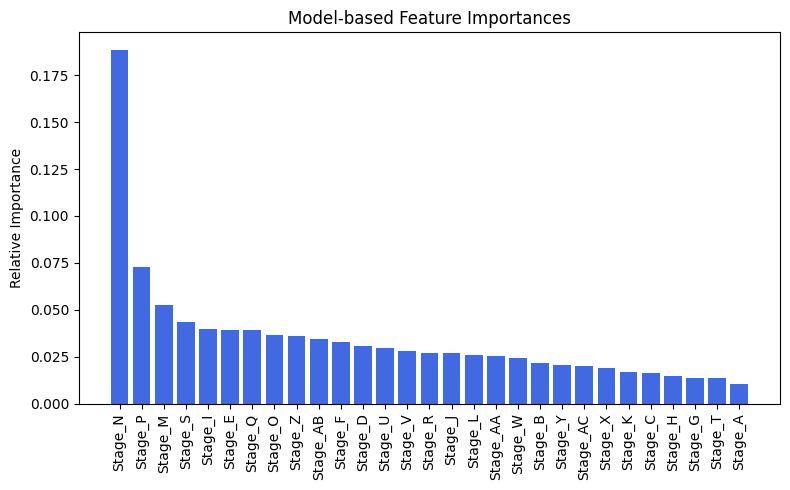

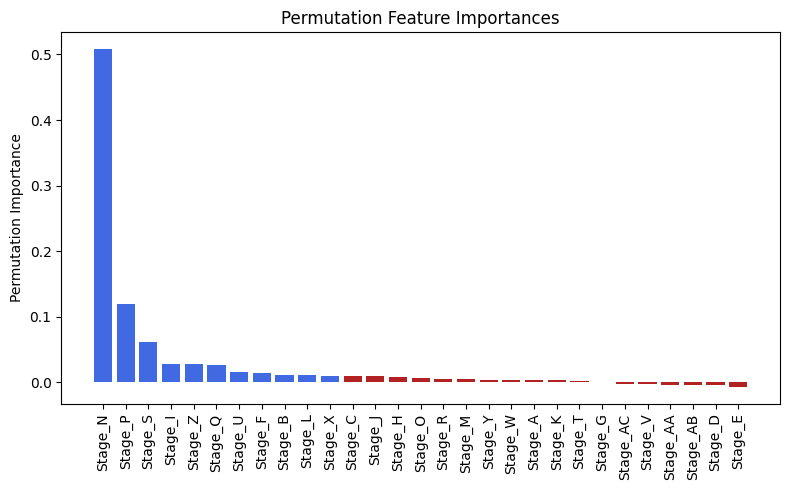

In [ ]:
# Obtain the importances from random forest
rf = RandomForestRegressor(n_estimators=100, random_state=seed)
rf.fit(X_train_A_le, Y_train_A)
model_based_rf, permutation_rf = get_importances(rf, X_train_A_le, X_test_A_le, Y_train_A, Y_test_A)

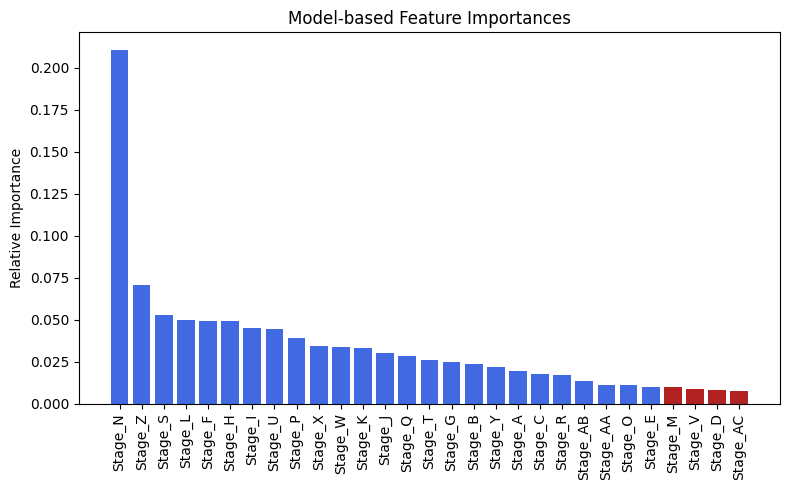

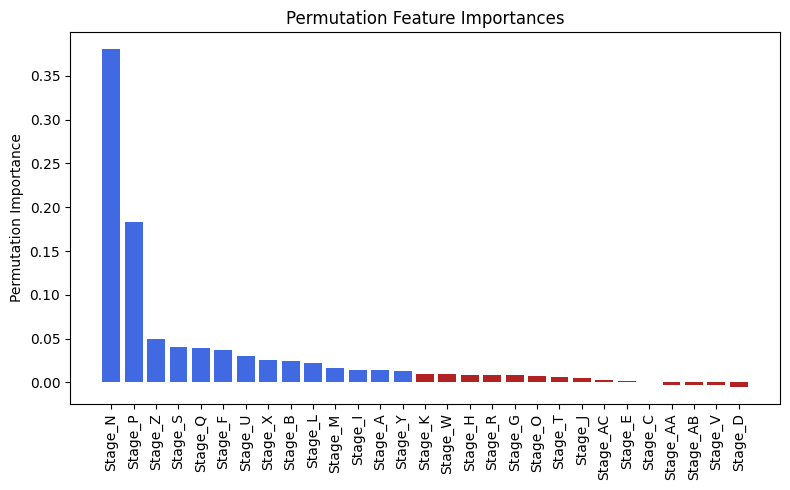

In [ ]:
# Obtain the importances from XGBoost
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=seed)
xgb.fit(X_train_A_le, Y_train_A)
model_based_xgb, permutation_xgb = get_importances(xgb, X_train_A_le, X_test_A_le, Y_train_A, Y_test_A)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 3486, number of used features: 29
[LightGBM] [Info] Start training from score 0.535848


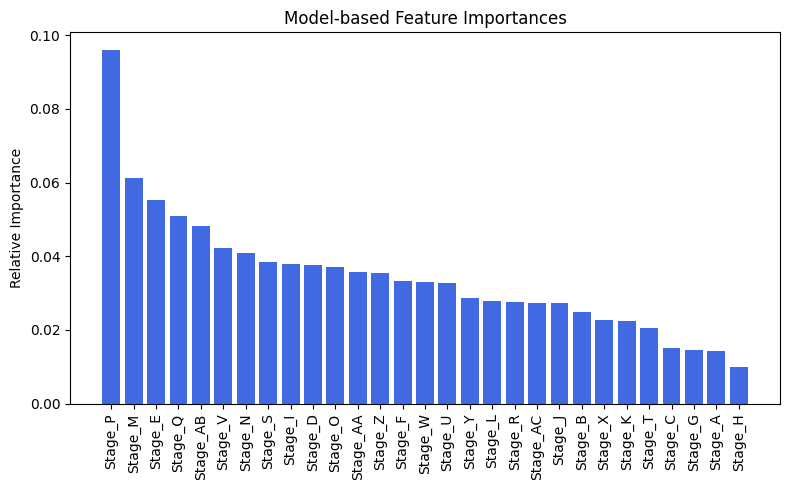

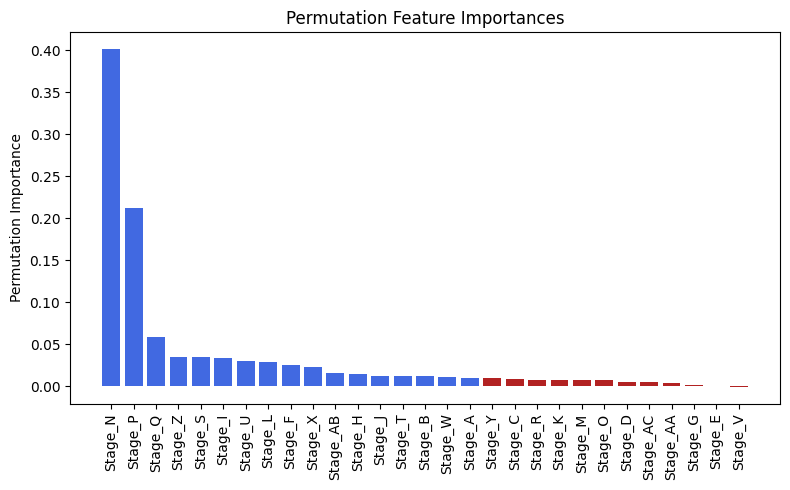

In [ ]:
# Initialize the LightGBM model
lgbm = lgb.LGBMRegressor(n_estimators=100, random_state=seed)
lgbm.fit(X_train_A_le, Y_train_A)

# Obtain model-based importances
importance_lgbm = lgbm.feature_importances_
normalized_importance_lgbm = importance_lgbm / sum(importance_lgbm)

indices = np.argsort(normalized_importance_lgbm)[::-1]
colors = ['firebrick' if normalized_importance_lgbm[i] < 0.01 else 'royalblue' for i in indices]

model_based_lgbm = pd.DataFrame({'Feature': X_train_A_le.columns, 'Importance': normalized_importance_lgbm}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.title("Model-based Feature Importances")
plt.bar(range(len(indices)), normalized_importance_lgbm[indices], align='center', color=colors)
plt.xticks(range(len(indices)), [X_train_A_le.columns[i] for i in indices], rotation=90)
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.show()

# Obtain permutation-based importances
result = permutation_importance(lgbm, X_test_A_le, Y_test_A, n_repeats=30, random_state=seed)
sorted_idx = result.importances_mean.argsort()[::-1]
colors = ['firebrick' if result.importances_mean[i] < 0.01 else 'royalblue' for i in sorted_idx]

permutation_lgbm = pd.DataFrame({'Feature': X_test_A_le.columns, 'Importance': result.importances_mean}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.title("Permutation Feature Importances")
plt.bar(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center', color=colors)
plt.xticks(range(len(sorted_idx)), [X_test_A_le.columns[i] for i in sorted_idx], rotation=90)
plt.ylabel("Permutation Importance")
plt.tight_layout()
plt.show()

**Model-based method**
* In Random Forest and XGBoost, "Stage_N" is particularly prominent and has the highest importance, and "Stage_P" have the highest importance in LightGBM.
* Unlike others, the importance attenuation of LightGBM features is slower,indicating that the model has a better use of each feature for training.
* In ensemble methods like Random Forest or Gradient Boosted Trees, the model usually consists of multiple trees and is trained in multiple iterations. During this multiple training process, the model is able to more accurately assess the importance of each feature.

**Permutation method**
* In the more objective Permutation method, the importance of "Stage_N" is far higher than other features, even as high as 0.5 or more in the random forest, indicating the importance of this feature.
* In addition to "Stage_N", "Stage_P" ranks second among all models in the Permutation method, reveals its importance.
* The importance of other features is very low compared to the first two.
* All three models have about half of the feature importances below 0.01.

In [ ]:
# Find the low importance features below threshold
def importance_below_threshold(df, threshold):
    below_threshold_features = df[df['Importance'] < threshold]['Feature'].tolist()
    return below_threshold_features

In [ ]:
# Check the feature importances below 0.01 of Random Forest model
low_importance_model_based_rf = importance_below_threshold(model_based_rf, threshold)
low_importance_permutation_rf = importance_below_threshold(permutation_rf, threshold)

print('----Low importance features of Random Forest----')
print("Features with model-based importance < 0.01:\n", low_importance_model_based_rf)
print("Features with permutation importance < 0.01:\n", low_importance_permutation_rf)
print("Features in both model-based and permutation methods:\n",\
      set(low_importance_model_based_rf) & set(low_importance_permutation_rf))

----Low importance features of Random Forest----
Features with model-based importance < 0.01:
 []
Features with permutation importance < 0.01:
 ['Stage_C', 'Stage_J', 'Stage_H', 'Stage_O', 'Stage_R', 'Stage_M', 'Stage_Y', 'Stage_W', 'Stage_A', 'Stage_K', 'Stage_T', 'Stage_G', 'Stage_AC', 'Stage_V', 'Stage_AA', 'Stage_AB', 'Stage_D', 'Stage_E']
Features in both model-based and permutation methods:
 set()


In [ ]:
# Check the feature importances below 0.01 of XGBoost model
low_importance_model_based_xgb = importance_below_threshold(model_based_xgb, threshold)
low_importance_permutation_xgb = importance_below_threshold(permutation_xgb, threshold)

print('----Low importance features of XGBoost----')
print("Features with model-based importance < 0.01:\n", low_importance_model_based_xgb)
print("Features with permutation importance < 0.01:\n", low_importance_permutation_xgb)
print("Features in both model-based and permutation methods:\n",\
      set(low_importance_model_based_xgb) & set(low_importance_permutation_xgb))

----Low importance features of XGBoost----
Features with model-based importance < 0.01:
 ['Stage_M', 'Stage_V', 'Stage_D', 'Stage_AC']
Features with permutation importance < 0.01:
 ['Stage_K', 'Stage_W', 'Stage_H', 'Stage_R', 'Stage_G', 'Stage_O', 'Stage_T', 'Stage_J', 'Stage_AC', 'Stage_E', 'Stage_C', 'Stage_AA', 'Stage_AB', 'Stage_V', 'Stage_D']
Features in both model-based and permutation methods:
 {'Stage_AC', 'Stage_D', 'Stage_V'}


In [ ]:
# Check the feature importances below 0.01 of LightGBM model
low_importance_model_based_lgbm = importance_below_threshold(model_based_lgbm, threshold)
low_importance_permutation_lgbm = importance_below_threshold(permutation_lgbm, threshold)

print('----Low importance features of LightGBM----')
print("Features with model-based importance < 0.01:\n", low_importance_model_based_lgbm)
print("Features with permutation importance < 0.01:\n", low_importance_permutation_lgbm)
print("Features in both model-based and permutation methods:\n",\
      set(low_importance_model_based_lgbm) & set(low_importance_permutation_lgbm))

----Low importance features of LightGBM----
Features with model-based importance < 0.01:
 []
Features with permutation importance < 0.01:
 ['Stage_Y', 'Stage_C', 'Stage_R', 'Stage_K', 'Stage_M', 'Stage_O', 'Stage_D', 'Stage_AC', 'Stage_AA', 'Stage_G', 'Stage_E', 'Stage_V']
Features in both model-based and permutation methods:
 set()



* Different models perceive the importance of features differently, a reflection of their inherent mechanisms and biases.
* The permutation method often identifies a more extensive list of low-importance features compared to model-based methods. This could be due to its more objective nature and its focus on evaluating the actual impact of each feature on model performance.
* Features that are consistently identified as low importance across models and methods, such as "Stage_G" for LightGBM and "Stage_A" for Random Forest, didn't take a main place for importance for all models, and might genuinely have limited influence on the target variable. It could be worth considering whether these features should be retained in future modeling iterations.

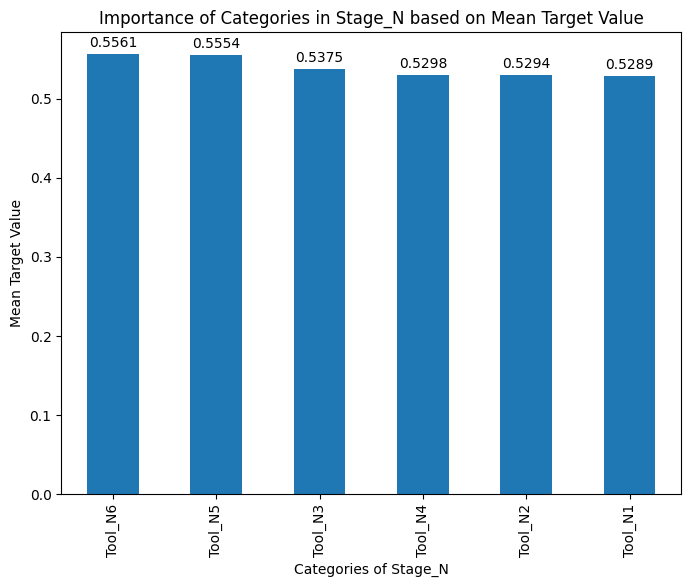

In [ ]:
# Calculate the mean target value for each category in 'Stage_N'
inverse_map_B = {col: {v: k for k, v in target_map_B[col].items()} for col in freq_map_B}

train_importances = pd.concat([X_train_B_target, Y_train_B], axis=1)
train_importances['Stage_N'] = train_importances['Stage_N'].map(inverse_map_B['Stage_N'])

grouped_stage_N = train_importances.groupby('Stage_N')['Mean'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
grouped_stage_N.plot(kind='bar')
plt.title("Importance of Categories in Stage_N based on Mean Target Value")
plt.ylabel("Mean Target Value")
plt.xlabel("Categories of Stage_N")

for index, value in enumerate(grouped_stage_N):
    plt.text(index, value + 0.005, f"{value:.4f}", ha='center', va='bottom')

plt.show()

Unlike One-Hot Encoding, when using such as frequency or target encoding, the importance of specific categories is not directly intuitive. So, when trying to understand the key categories of a feature under this circumstance, one can determine which categories have the most significant impact on the target by examining the average order of the categories.

From the results, it can be observed that within the Stage_N feature, the target values are somewhat uniform. However, **Tool_N6** and **Tool_N5** stand out slightly above the other categories, with a minimal difference between their values. This suggests that these two tools are the more critical categories.

## 4.3 Re-train the Model

### 4.3.1 Backward Selection

In the analysis of feature importance, the model's inherent mechanism determines its significance. The outcomes from permutation tests across the three models are notably consistent. In this segment, we employ backward elimination based on the importance derived from each model. By systematically removing the least significant features one at a time, to evaluate the effectiveness of our feature selection.

In [ ]:
# Define backward feature evaluation
def backward_feature_evaluation(importance_df, model, X_train, X_test, Y_train, Y_test):
  results = pd.DataFrame(columns=['Dropped Feature', 'R^2'])
  features_sorted = importance_df.sort_values(by='Importance', ascending=True)['Feature'].tolist()

  for feature in features_sorted:
    Yhat = model.fit(X_train, Y_train).predict(X_test)
    r2 = r2_score(Y_test, Yhat)

    # Append the result to result
    new_row = pd.DataFrame({'Dropped Feature': [feature], 'R^2': [r2]})
    results = pd.concat([results, new_row], ignore_index=True)
    # Delete column from dataset
    X_train = X_train.drop(columns=[feature])
    X_test = X_test.drop(columns=[feature])

  # Plot the result
  plt.figure(figsize=(8, 5))
  plt.plot(results['Dropped Feature'], results['R^2'], marker='o')
  plt.xticks(rotation=90)
  plt.xlabel('Dropped Feature')
  plt.ylabel('R^2')
  plt.title('R^2 after dropping each feature')
  plt.tight_layout()
  plt.show()

  return results

In [ ]:
# Random Forest Regressor
rf_bs = RandomForestRegressor(n_estimators=100, random_state=seed)

# XGBsst
xgb_bs = xgb = XGBRegressor(n_estimators=100, random_state=seed)

# LightGBM
lgbm_bs = lgb.LGBMRegressor(n_estimators=100, random_state=seed, verbose=-1)

#### Backward selection for Random Forest

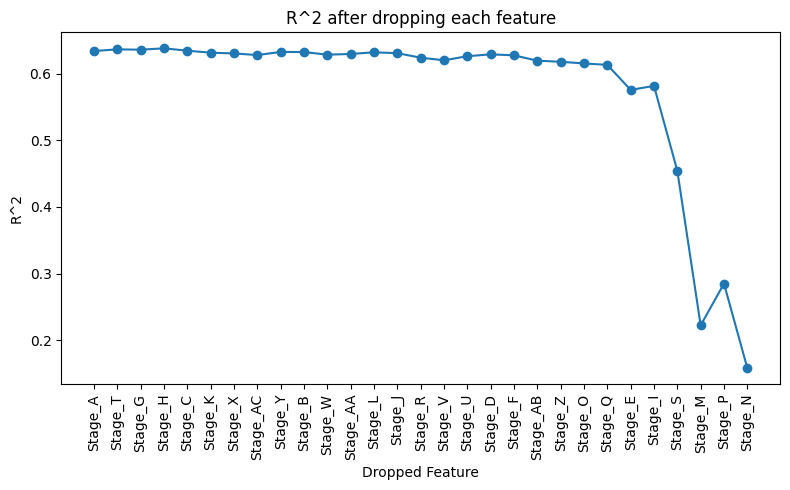

In [ ]:
model_based_r2_drop_rf = backward_feature_evaluation(model_based_rf, rf_bs, X_train_A_le, X_test_A_le, Y_train_A, Y_test_A)

In [ ]:
print(model_based_r2_drop_rf[model_based_r2_drop_rf['R^2'] == model_based_r2_drop_rf['R^2'].max()])

  Dropped Feature      R^2
3         Stage_H  0.63828


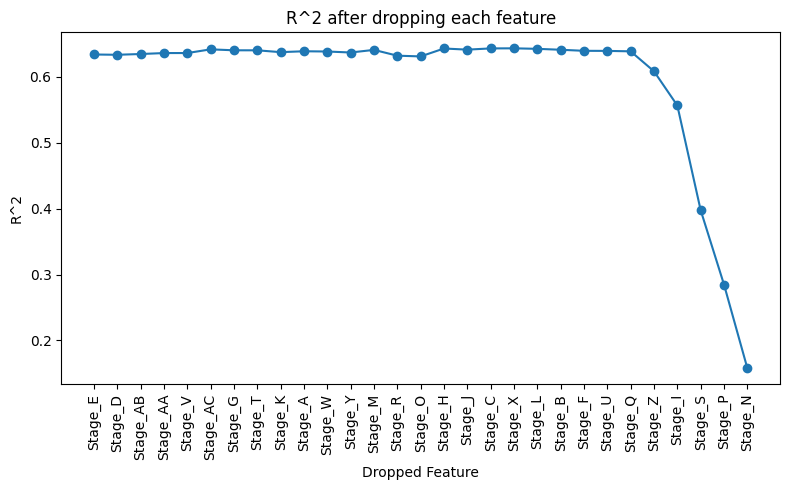

In [ ]:
permutation_r2_drop_rf = backward_feature_evaluation(permutation_rf, rf_bs, X_train_A_le, X_test_A_le, Y_train_A, Y_test_A)

In [ ]:
print(permutation_r2_drop_rf[permutation_r2_drop_rf['R^2'] == permutation_r2_drop_rf['R^2'].max()])

   Dropped Feature       R^2
18         Stage_X  0.643524


#### Backward selection for XGBoost

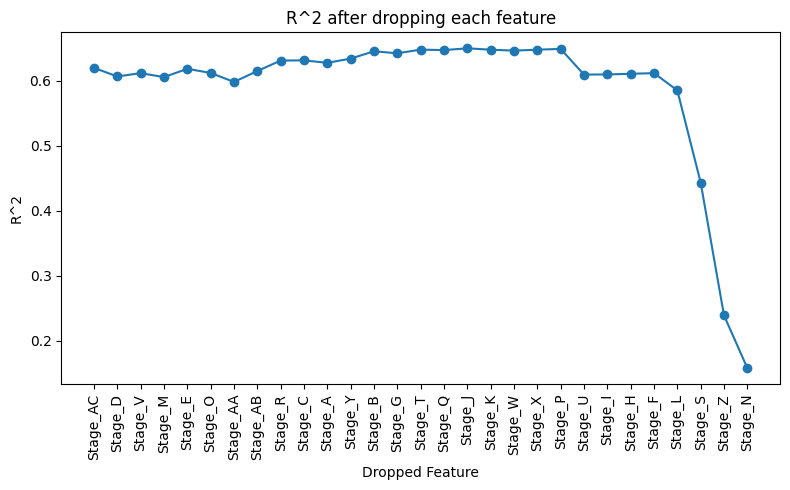

In [ ]:
model_based_r2_drop_xgb = backward_feature_evaluation(model_based_xgb, xgb_bs, X_train_A_le, X_test_A_le, Y_train_A, Y_test_A)

In [ ]:
print(model_based_r2_drop_xgb[model_based_r2_drop_xgb['R^2'] == model_based_r2_drop_xgb['R^2'].max()])

   Dropped Feature       R^2
16         Stage_J  0.649729


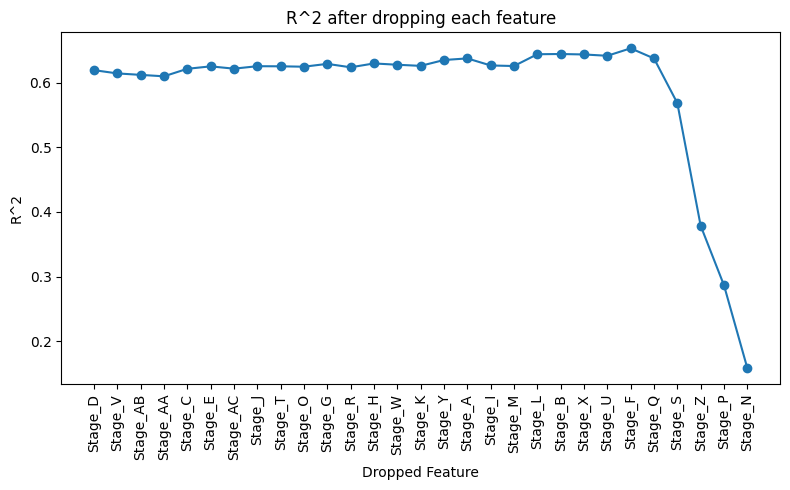

In [ ]:
permutation_r2_drop_xgb = backward_feature_evaluation(permutation_xgb, xgb_bs, X_train_A_le, X_test_A_le, Y_train_A, Y_test_A)

In [ ]:
print(permutation_r2_drop_xgb[permutation_r2_drop_xgb['R^2'] == permutation_r2_drop_xgb['R^2'].max()])

   Dropped Feature       R^2
23         Stage_F  0.653517


#### Backward selection for LightGBM

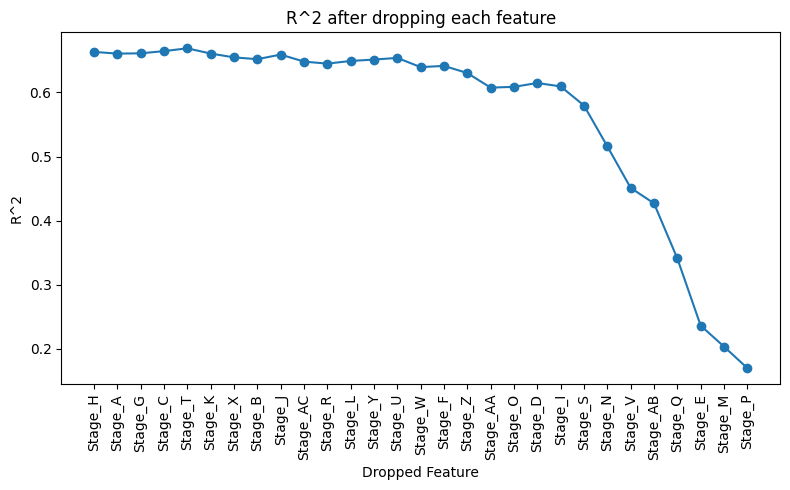

In [ ]:
model_based_r2_drop_lgbm = backward_feature_evaluation(model_based_lgbm, lgbm_bs, X_train_A_le, X_test_A_le, Y_train_A, Y_test_A)

In [ ]:
print(model_based_r2_drop_lgbm[model_based_r2_drop_lgbm['R^2'] == model_based_r2_drop_lgbm['R^2'].max()])

  Dropped Feature       R^2
4         Stage_T  0.668857


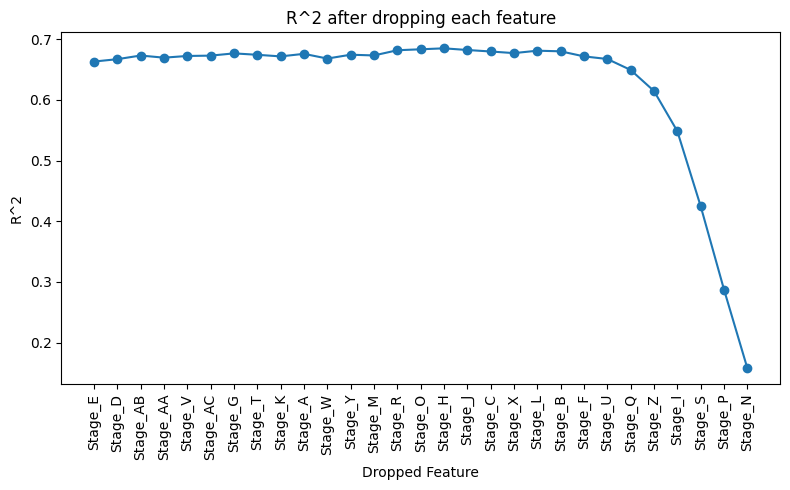

In [ ]:
permutation_r2_drop_lgbm = backward_feature_evaluation(permutation_rf, lgbm_bs, X_train_A_le, X_test_A_le, Y_train_A, Y_test_A)

In [ ]:
print(permutation_r2_drop_lgbm[permutation_r2_drop_lgbm['R^2'] == permutation_r2_drop_lgbm['R^2'].max()])

   Dropped Feature       R^2
15         Stage_H  0.685096


From the results of the backward selection process:
* In comparison to the model-based approach, utilizing permutation importance for feature selection tends to enhance the performance of each model.
* The permutation results indicate that each model eliminated approximately half of the features. This suggests that nearly half of the processing procedures might not play a crucial role in determining wafer performance.
* An overarching observation is that the elimination of seemingly less important features doesn't necessarily lead to a substantial improvement in model performance.
* Among all, LightGBM's feature selection, based on permutation importance, boasts the highest R^2 value of 0.685.

### 4.3.2 RandomizedSearchCV

In [ ]:
# Drop the unimportance features
selected_features = permutation_r2_drop_lgbm['Dropped Feature'][15:]

X_train_final = X_train_A_le[selected_features]
X_test_final = X_test_A_le[selected_features]
Y_train_final = Y_train_A.copy() # To uniform the name, just in case :)
Y_test_final = Y_test_A.copy()

In [ ]:
print('Shape of X_train_final: ', X_train_final.shape)
print('Shape of Y_train_final: ', Y_train_final.shape)
print('Shape of X_test_final: ', X_test_final.shape)
print('Shape of Y_test_final: ', Y_test_final.shape)

Shape of X_train_final:  (3486, 14)
Shape of Y_train_final:  (3486,)
Shape of X_test_final:  (872, 14)
Shape of Y_test_final:  (872,)


In [ ]:
# Define function to obtain the residuals and Q-Q plot
def get_residual_qqplt(Y_test, Yhat):
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

  # Residuasl plot
  residuals = Y_test - Yhat

  ax0.scatter(Yhat, residuals)
  ax0.axhline(0, color='red', linestyle='--')
  ax0.set_xlabel('Predicted Values')
  ax0.set_ylabel('Residuals')
  ax0.set_title('Residual Plot')

  # Q-Q plot
  sm.qqplot(residuals, line='s', ax=ax1)
  ax1.set_title('Q-Q plot')

  plt.show()

#### Random Forest Optimization

In [ ]:
%%capture
# Define hyper parameters for Random Forest
parameters = {
     'max_depth': [2*n for n in range(1,10)],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [100, 200, 300, 500],
     'max_features': ['sqrt', 'log2'],
     'bootstrap': [True, False]}

# Create RandomizedSearchCV for RandomForestRegressor
rf = RandomForestRegressor(random_state=seed)
rf_cv = RandomizedSearchCV(rf, param_distributions=parameters, n_iter=100, cv=5, n_jobs=-1, random_state=seed)


rf_cv.fit(X_train_final, Y_train_final)
rf_best_params = rf_cv.best_params_

In [ ]:
print('Tuned hyperparameters: ', rf_best_params)
print('Best R^2: ', rf_cv.best_score_.round(3))

Tuned hyperparameters:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': True}
Best R^2:  0.667


In [ ]:
# Record the best parameters
tuned_params_rf = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': True}
rf_best = RandomForestRegressor(**tuned_params_rf, random_state=seed)

start_time = time.time()
Yhat = rf_best.fit(X_train_final, Y_train_final).predict(X_test_final)
end_time = time.time()
elapsed_time = (end_time - start_time)
elapsed_time = round(elapsed_time, 3)

score_rf = get_evaluation_metrics(Y_test_final, Yhat, rf_best)
score_rf['Training Time'] = elapsed_time
score_rf

{'Model': 'RandomForestRegressor',
 'RMSE': 0.014,
 'MAE': 0.011,
 'R^2': 0.667,
 'Training Time': 0.827}

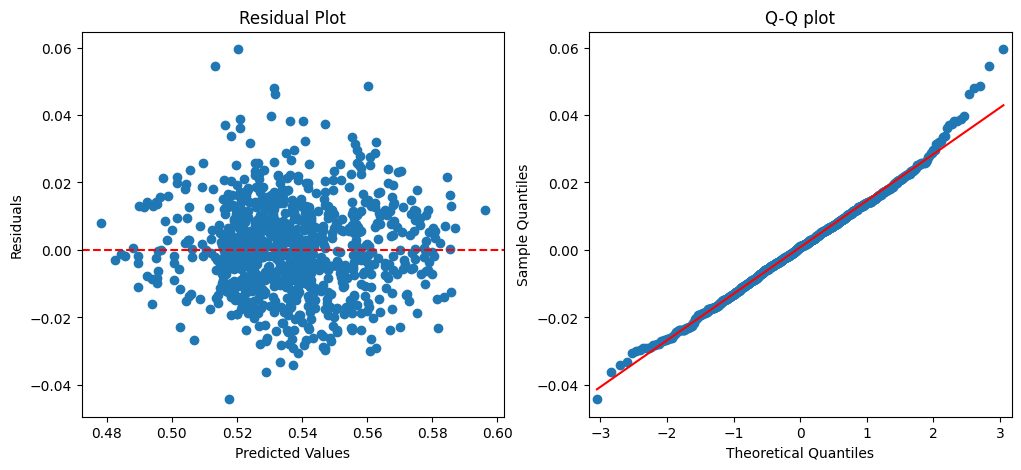

In [ ]:
get_residual_qqplt(Y_test_final, Yhat)

#### XGBoost Optimization

In [ ]:
# Define hyper parameters for XGBoost
parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 10),
    'min_child_weight': randint(1, 20),
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2],
    'booster': ['gbtree', 'gblinear', 'dart']}

# Create RandomizedSearchCV for XGBoost
xgb = XGBRegressor(random_state=seed)
xgb_cv = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=100, cv=5, verbose=1, n_jobs=-1, random_state=seed)
xgb_cv.fit(X_train_final, Y_train_final)
xgb_best_params = xgb_cv.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
print('Tuned hyperparameters: ', xgb_best_params)
print('Best R^2: ', xgb_cv.best_score_.round(3))

Tuned hyperparameters:  {'booster': 'gbtree', 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 346, 'reg_alpha': 0, 'reg_lambda': 0.5}
Best R^2:  0.686


In [ ]:
tuned_params_xgb = {'booster': 'dart', 'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 275, 'reg_alpha': 0.1, 'reg_lambda': 2}
xgb_best = XGBRegressor(**tuned_params_xgb, random_state=seed)

start_time = time.time()
Yhat = xgb_best.fit(X_train_final, Y_train_final).predict(X_test_final)
end_time = time.time()
elapsed_time = (end_time - start_time)
elapsed_time = round(elapsed_time, 3)

score_xgb = get_evaluation_metrics(Y_test_final, Yhat, xgb_best)
score_xgb['Training Time'] = elapsed_time

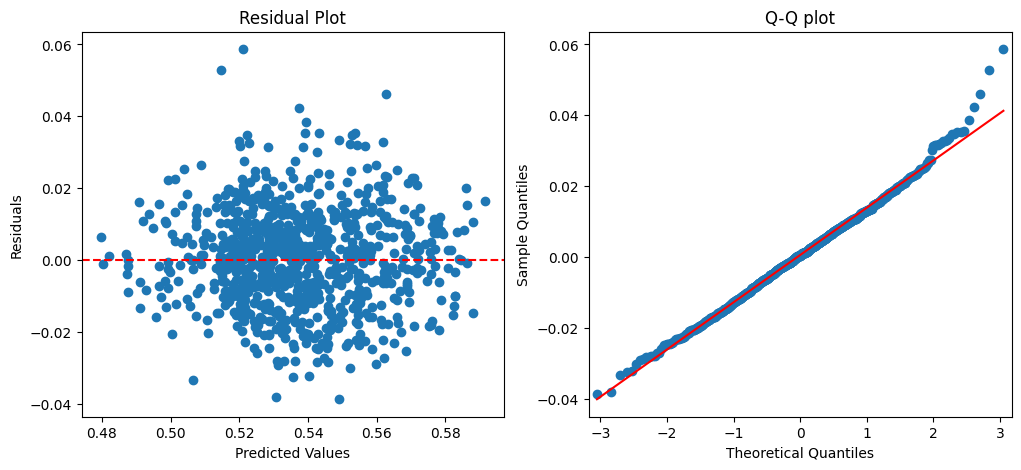

In [ ]:
get_residual_qqplt(Y_test_final, Yhat)

#### LightGBM

In [ ]:
# Define hyper parameters for LightGBM
parameters_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 10),
    'min_child_weight': randint(1, 20),
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'num_leaves': randint(20, 50)}

# Create RandomizedSearchCV for LightGBM
lgbm = lgb.LGBMRegressor(random_state=seed, verbose=-1)
lgbm_cv = RandomizedSearchCV(lgbm, param_distributions=parameters_lgbm, n_iter=100, cv=5, verbose=-1, n_jobs=-1, random_state=seed)
lgbm_cv.fit(X_train_final, Y_train_final)
lgbm_best_params = lgbm_cv.best_params_

In [ ]:
print('Tuned hyperparameters: ', lgbm_best_params)
print('Best R^2: ', lgbm_cv.best_score_.round(3))

Tuned hyperparameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 334, 'num_leaves': 38, 'subsample': 1.0}
Best R^2:  0.688


In [ ]:
tuned_params_lgbm = {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 334, 'num_leaves': 38, 'subsample': 1.0}
lgbm_best = lgb.LGBMRegressor(**tuned_params_lgbm, random_state=seed, verbose=-1)

start_time = time.time()
lgbm_best.fit(X_train_final, Y_train_final)
end_time = time.time()
elapsed_time = (end_time - start_time)
elapsed_time = round(elapsed_time, 3)

Yhat = lgbm_best.predict(X_test_final)
score_lgbm = get_evaluation_metrics(Y_test_final, Yhat, lgbm_best)
score_lgbm['Training Time'] = elapsed_time
score_lgbm

{'Model': 'LGBMRegressor',
 'RMSE': 0.013,
 'MAE': 0.01,
 'R^2': 0.69,
 'Training Time': 0.192}

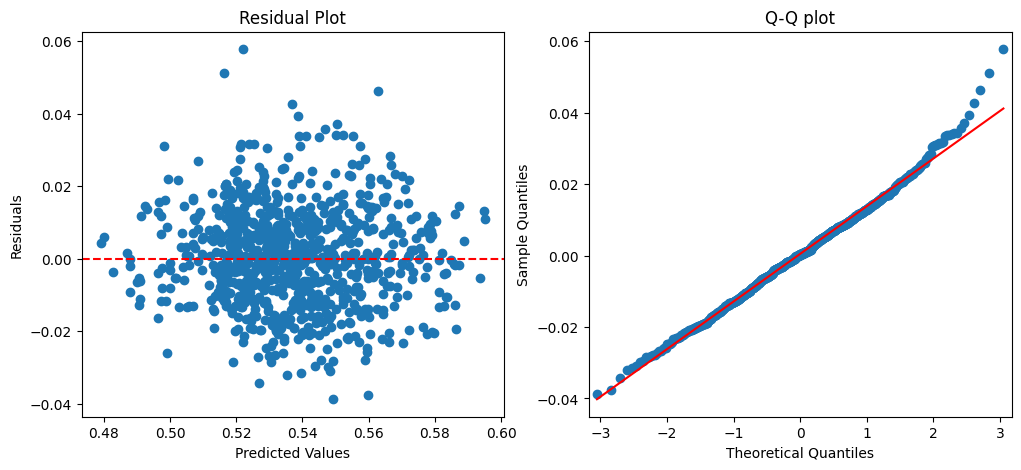

In [ ]:
get_residual_qqplt(Y_test_final, Yhat)

### 4.4.3 Final Performance

In [ ]:
result_df = pd.DataFrame([score_rf, score_xgb, score_lgbm])
result_df

,Model,RMSE,MAE,R^2,Training Time
0,RandomForestRegressor,0.014,0.011,0.667,0.827
1,XGBRegressor,0.013,0.010,0.689,11.171
2,LGBMRegressor,0.013,0.010,0.690,0.192


After searching for the best parameter optimization model, it can be obtained from the performance table:
* All three models have comparable performance, with LightGBM and XGBoost having a slight advantage over Random Forest regressors.
* The RMSE and MAE metrics differences between the models are relatively small, but since LightGBM's training time is very competitive and LightGBM consistently shows the highest performance, it seems to be the best model for this dataset.

The residual plots and Q-Q plots across all models exhibit similar patterns, suggesting that their performances are comparable.

The residual plots display a circular distribution, hinting at potential non-linear associations that might not have been fully captured by the models. Even though our current models are intrinsically non-linear, the observed pattern in residuals could be due to complex interactions between features, which aren't explicitly modeled. To better capture such intricate relationships, we could consider using neural networks, which excel at modeling high-level interactions. Or considering creating new cross-interaction features to help the model capture more pieces of information.

On the other hand, the Q-Q plot aligns closely with the normal distribution line, indicating that the residuals are approximately normally distributed. This is a positive sign, suggesting that the assumptions of homoscedasticity and normality of errors, critical for many regression models, are largely met.

# 5. Prediction Output

In [ ]:
# Prepare the prediction data - applying label encoding
predict_A.reset_index(drop=True, inplace=True)
predict_data = predict_A.copy().drop('Wafer ID', axis=1)
predict_data.head()

,Stage_A,Stage_B,Stage_C,Stage_D,Stage_E,Stage_F,Stage_G,Stage_H,Stage_I,Stage_J,...,Stage_U,Stage_V,Stage_W,Stage_X,Stage_Y,Stage_Z,Stage_AA,Stage_AB,Stage_AC,Mean
0,330.0,Tool_B5,Tool_C2,Tool_D3,Tool_E11,Tool_F11,Tool_G3,Tool_H2,Tool_I2,Tool_J7,...,Tool_U4,Tool_V7,Tool_W4,Tool_X5,Tool_Y11,Tool_Z10,Tool_AA2,Tool_AB1,Tool_AC8,NaN
1,330.0,Tool_B6,Tool_C3,Tool_D12,Tool_E20,Tool_F19,Tool_G4,Tool_H2,Tool_I10,Tool_J3,...,Tool_U8,Tool_V16,Tool_W1,Tool_X4,Tool_Y5,Tool_Z1,others,Tool_AB18,Tool_AC8,NaN
2,330.0,Tool_B6,Tool_C2,Tool_D4,Tool_E21,Tool_F12,Tool_G3,Tool_H2,Tool_I9,Tool_J1,...,Tool_U1,Tool_V27,Tool_W12,Tool_X5,Tool_Y5,Tool_Z9,Tool_AA14,Tool_AB12,Tool_AC5,NaN
3,330.0,Tool_B2,Tool_C2,Tool_D13,others,Tool_F5,Tool_G2,Tool_H4,Tool_I10,Tool_J7,...,Tool_U11,Tool_V27,Tool_W15,Tool_X5,Tool_Y3,Tool_Z11,Tool_AA11,Tool_AB15,Tool_AC5,NaN
4,320.0,Tool_B1,Tool_C2,Tool_D10,Tool_E21,Tool_F14,Tool_G4,Tool_H2,Tool_I5,Tool_J5,...,Tool_U5,Tool_V10,Tool_W4,Tool_X3,Tool_Y10,Tool_Z2,Tool_AA13,Tool_AB3,Tool_AC4,NaN


In [ ]:
# Applying label encoding
X_train, X_pred, le_dict = label_encode_data(X_train_A, predict_data)

# Feature selection
X_pred = X_pred[selected_features]
X_pred.head()

,Stage_H,Stage_J,Stage_C,Stage_X,Stage_L,Stage_B,Stage_F,Stage_U,Stage_Q,Stage_Z,Stage_I,Stage_S,Stage_P,Stage_N
0,0,7,1,4,3,4,2,5,10,1,6,4,5,2
1,0,3,2,3,4,5,10,9,3,0,0,11,13,2
2,0,0,1,4,1,5,3,0,6,10,11,12,13,5
3,2,7,1,4,8,1,13,2,2,2,0,14,10,1
4,0,5,1,2,0,0,5,6,3,3,9,1,8,2


In [ ]:
# Prediction
output = lgbm_best.predict(X_pred)
output_df = pd.DataFrame(output)

In [ ]:
final_output = pd.concat([predict_A['Wafer ID'], output_df], axis=1)
final_output.rename(columns={0: 'Prediction'}, inplace=True)
final_output.head()

,Wafer ID,Prediction
0,Wafer_5264,0.540191
1,Wafer_2774,0.514741
2,Wafer_732,0.568807
3,Wafer_4448,0.572110
4,Wafer_3454,0.517590


In [ ]:
final_output.to_csv('final_results.csv', index=False)